<a href="https://colab.research.google.com/github/ryukir11/Tugas-Akhir/blob/main/AUS_RIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade yfinance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from tensorflow.keras.optimizers import Adam
import math
import plotly.express as px
import plotly.figure_factory as ff
import yfinance as yf
import statsmodels.api as sm
from statistics import mode
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis
import plotly.graph_objects as go
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
data = yf.download('^AXJO', start='2000-01-04', end='2024-04-30')

scaler = MinMaxScaler()
def scaling_data(data):
    features = [features for features in data.columns]
    data[features] = scaler.fit_transform(data[features])
    return data

data = scaling_data(data)
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open    Volume
Ticker         ^AXJO     ^AXJO     ^AXJO     ^AXJO     ^AXJO
Date                                                        
2000-01-04  0.075686  0.072283  0.077379  0.075686  0.000000
2000-01-05  0.061253  0.057838  0.062885  0.061253  0.000000
2000-01-06  0.057520  0.054101  0.059136  0.057520  0.000000
2000-01-07  0.062157  0.058743  0.063794  0.062157  0.000000
2000-01-10  0.073819  0.070415  0.075505  0.073819  0.000000
...              ...       ...       ...       ...       ...
2024-04-22  0.952333  0.955336  0.941927  0.936573  0.000354
2024-04-23  0.958934  0.958475  0.957619  0.952333  0.000418
2024-04-24  0.958838  0.964080  0.963649  0.958934  0.000428
2024-04-26  0.938228  0.956183  0.942081  0.958838  0.000384
2024-04-29  0.950063  0.949134  0.943589  0.938228  0.000399

[6143 rows x 5 columns]

In [ ]:
data2 = yf.download('^AXJO', start='2000-01-04', end='2024-04-30')
mini = data2['Close'].min()
max = data2['Close'].max()
price_range = max-mini
range_value = price_range.iloc[0]
range_value

[*********************100%***********************]  1 of 1 completed


np.float64(5196.5)

In [ ]:
ret_df = data['Close']
def windowed_df(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][-1]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

In [ ]:
X, y, dates = windowed_df(ret_df, 5)

In [ ]:
data['Date'] = pd.to_datetime(data.index)

data.set_index('Date', inplace=True)

all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

data_full = data.reindex(all_dates)

data_full = data_full.interpolate(method='linear')

data_full = data_full.reset_index()
data_full.rename(columns={'index': 'Date'}, inplace=True)
df = data_full.copy()
print(data_full)

Price        Date     Close      High       Low      Open    Volume
Ticker                ^AXJO     ^AXJO     ^AXJO     ^AXJO     ^AXJO
0      2000-01-04  0.075686  0.072283  0.077379  0.075686  0.000000
1      2000-01-05  0.061253  0.057838  0.062885  0.061253  0.000000
2      2000-01-06  0.057520  0.054101  0.059136  0.057520  0.000000
3      2000-01-07  0.062157  0.058743  0.063794  0.062157  0.000000
4      2000-01-08  0.066044  0.062634  0.067697  0.066044  0.000000
...           ...       ...       ...       ...       ...       ...
8878   2024-04-25  0.948533  0.960132  0.952865  0.958886  0.000406
8879   2024-04-26  0.938228  0.956183  0.942081  0.958838  0.000384
8880   2024-04-27  0.942173  0.953834  0.942584  0.951968  0.000389
8881   2024-04-28  0.946118  0.951484  0.943086  0.945098  0.000394
8882   2024-04-29  0.950063  0.949134  0.943589  0.938228  0.000399

[8883 rows x 6 columns]


In [ ]:
def calculate_forward_trend_duration1(prices):
    n = len(prices)
    durations = [1] * n
    for i in range(n-1):
        count = 0
        j = i + 1

        if prices[j] > prices[i]:
            trend = "up"
        elif prices[j] < prices[i]:
            trend = "down"
        else:
            trend = "none"

        while j < n:
            if trend == "up" and prices[j] > prices[j - 1]:
                count += 1
            elif trend == "down" and prices[j] < prices[j - 1]:
                count += 1
            else:
                break
            j += 1

        durations[i] = count
    return durations

data_full['Trend_Duration'] = calculate_forward_trend_duration1(data_full['Close'].values)
print(data_full)

Price        Date     Close      High       Low      Open    Volume  \
Ticker                ^AXJO     ^AXJO     ^AXJO     ^AXJO     ^AXJO   
0      2000-01-04  0.075686  0.072283  0.077379  0.075686  0.000000   
1      2000-01-05  0.061253  0.057838  0.062885  0.061253  0.000000   
2      2000-01-06  0.057520  0.054101  0.059136  0.057520  0.000000   
3      2000-01-07  0.062157  0.058743  0.063794  0.062157  0.000000   
4      2000-01-08  0.066044  0.062634  0.067697  0.066044  0.000000   
...           ...       ...       ...       ...       ...       ...   
8878   2024-04-25  0.948533  0.960132  0.952865  0.958886  0.000406   
8879   2024-04-26  0.938228  0.956183  0.942081  0.958838  0.000384   
8880   2024-04-27  0.942173  0.953834  0.942584  0.951968  0.000389   
8881   2024-04-28  0.946118  0.951484  0.943086  0.945098  0.000394   
8882   2024-04-29  0.950063  0.949134  0.943589  0.938228  0.000399   

Price  Trend_Duration  
Ticker                 
0                   2  
1   

## LSTM MODEL

In [ ]:
data_full.index = data_full['Date']
data_full

Price            Date     Close      High       Low      Open    Volume  \
Ticker                    ^AXJO     ^AXJO     ^AXJO     ^AXJO     ^AXJO   
Date                                                                      
2000-01-04 2000-01-04  0.075686  0.072283  0.077379  0.075686  0.000000   
2000-01-05 2000-01-05  0.061253  0.057838  0.062885  0.061253  0.000000   
2000-01-06 2000-01-06  0.057520  0.054101  0.059136  0.057520  0.000000   
2000-01-07 2000-01-07  0.062157  0.058743  0.063794  0.062157  0.000000   
2000-01-08 2000-01-08  0.066044  0.062634  0.067697  0.066044  0.000000   
...               ...       ...       ...       ...       ...       ...   
2024-04-25 2024-04-25  0.948533  0.960132  0.952865  0.958886  0.000406   
2024-04-26 2024-04-26  0.938228  0.956183  0.942081  0.958838  0.000384   
2024-04-27 2024-04-27  0.942173  0.953834  0.942584  0.951968  0.000389   
2024-04-28 2024-04-28  0.946118  0.951484  0.943086  0.945098  0.000394   
2024-04-29 2024-04-29  0.950063  0.949134  0.943589  0.938228  0.000399   

Price      Trend_Duration  
Ticker                     
Date                       
2000-01-04              2  
2000-01-05              1  
2000-01-06              5  
2000-01-07              4  
2000-01-08              3  
...                   ...  
2024-04-25              1  
2024-04-26              3  
2024-04-27              2  
2024-04-28              1  
2024-04-29              1  

[8883 rows x 7 columns]

In [ ]:
#Sliding Window
X_close, y_close, dates_close = windowed_df(data_full['Close'], 5)
n_total = len(X_close)
Mq_80 = int(n_total*0.8)
Mq_90 = int(n_total*0.9)
dates_train, X_train, y_train = dates_close[:Mq_80], X_close[:Mq_80], y_close[:Mq_80]
dates_val, X_val, y_val = dates_close[Mq_80:Mq_90], X_close[Mq_80:Mq_90], y_close[Mq_80:Mq_90]
dates_test, X_test, y_test = dates_close[Mq_90:], X_close[Mq_90:], y_close[Mq_90:]

In [ ]:
data_full.iloc[7101:7106]

Price            Date     Close      High       Low      Open    Volume  \
Ticker                    ^AXJO     ^AXJO     ^AXJO     ^AXJO     ^AXJO   
Date                                                                      
2019-06-14 2019-06-14  0.741576  0.739797  0.742043  0.739344  0.000432   
2019-06-15 2019-06-15  0.740094  0.739534  0.741656  0.740088  0.000429   
2019-06-16 2019-06-16  0.738613  0.739271  0.741270  0.740832  0.000426   
2019-06-17 2019-06-17  0.737131  0.739007  0.740883  0.741576  0.000422   
2019-06-18 2019-06-18  0.744655  0.742301  0.741328  0.737131  0.000635   

Price      Trend_Duration  
Ticker                     
Date                       
2019-06-14              3  
2019-06-15              2  
2019-06-16              1  
2019-06-17              3  
2019-06-18              2

In [ ]:
X_train[7101]

array([[0.74157608],
       [0.74009431],
       [0.73861253],
       [0.73713076],
       [0.74465508]])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
print(np.min(y_train))  # Harusnya > 0 kalau mau MAPE aman
print(np.sum(y_train == 0))

0.0
1


In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (5,1)),
    layers.Dropout(0.2),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

## CLOSE

In [ ]:
result = []
train_pred = []
val_pred = []
test_pred = []
histories = []
train_mapes = []
val_mapes = []
test_mapes = []

for i in range(30):
    print(f"\nTraining iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    checkpoint_path = f'best_weights_iter_{i+1}.weights.h5'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta= 0.0001,
        patience=20,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        batch_size=128,
        validation_data=(X_val, y_val),
        epochs=200,
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    result.append(history)
    histories.append(history.history)

    model.load_weights(checkpoint_path)

    train = model.predict(X_train, verbose=0).flatten()
    val = model.predict(X_val, verbose=0).flatten()
    test = model.predict(X_test, verbose=0).flatten()

    train_pred.append(train)
    val_pred.append(val)
    test_pred.append(test)

    mape_train = mean_absolute_percentage_error(y_train, train)
    mape_val = mean_absolute_percentage_error(y_val, val)
    mape_test = mean_absolute_percentage_error(y_test, test)

    train_mapes.append(mape_train)
    val_mapes.append(mape_val)
    test_mapes.append(mape_test)

    print(f"Iteration {i+1} - MAPE Train: {mape_train:.4f}, Val: {mape_val:.4f}, Test: {mape_test:.4f}")


Training iteration 1...
Iteration 1 - MAPE Train: 28711268816.9015, Val: 0.0511, Test: 0.0699

Training iteration 2...
Iteration 2 - MAPE Train: 26287301279.3745, Val: 0.0410, Test: 0.0419

Training iteration 3...
Iteration 3 - MAPE Train: 24540200623.2360, Val: 0.0433, Test: 0.0518

Training iteration 4...
Iteration 4 - MAPE Train: 29392260313.7728, Val: 0.0612, Test: 0.0872

Training iteration 5...
Iteration 5 - MAPE Train: 29632654999.0151, Val: 0.0384, Test: 0.0374

Training iteration 6...
Iteration 6 - MAPE Train: 28009984967.8190, Val: 0.0338, Test: 0.0308

Training iteration 7...
Iteration 7 - MAPE Train: 29838746395.9530, Val: 0.0486, Test: 0.0608

Training iteration 8...
Iteration 8 - MAPE Train: 29811180452.0654, Val: 0.0643, Test: 0.0926

Training iteration 9...
Iteration 9 - MAPE Train: 43715623031.5033, Val: 0.0300, Test: 0.0231

Training iteration 10...
Iteration 10 - MAPE Train: 27534593504.7665, Val: 0.0537, Test: 0.0711

Training iteration 11...
Iteration 11 - MAPE Tr

In [ ]:
best_index = np.argmin(val_mapes)
print(f"\nBest iteration: {best_index+1}")
print(f"Val MAPE: {val_mapes[best_index]:.4f}, Test MAPE: {test_mapes[best_index]:.4f}")


Best iteration: 18
Val MAPE: 0.0229, Test MAPE: 0.0164


In [ ]:
model.load_weights(f'best_weights_iter_{best_index+1}.weights.h5')

In [ ]:
train_df = pd.DataFrame(train_pred).transpose()
val_df = pd.DataFrame(val_pred).transpose()
test_df = pd.DataFrame(test_pred).transpose()

train_df.columns = [f'Iterasi {i+1}' for i in range(train_df.shape[1])]
val_df.columns = [f'Iterasi {i+1}' for i in range(val_df.shape[1])]
test_df.columns = [f'Iterasi {i+1}' for i in range(test_df.shape[1])]

train_df['Rata2'] = train_df.mean(axis=1)
val_df['Rata2'] = val_df.mean(axis=1)
test_df['Rata2'] = test_df.mean(axis=1)

train_df.index = dates_train
val_df.index = dates_val
test_df.index = dates_test

In [ ]:
train_df = train_df.multiply(range_value)
train_df.to_csv('hasiltrainlstm_AUSTRALIA.csv')
train_df

Iterasi 1    Iterasi 2    Iterasi 3    Iterasi 4    Iterasi 5  \
2000-01-09   380.285767   383.809113   390.938660   382.779114   391.697021   
2000-01-10   362.985382   366.110748   370.899780   367.054688   374.349396   
2000-01-11   366.319580   371.288116   375.252106   371.105225   378.961426   
2000-01-12   380.899597   388.636627   392.870453   386.406281   395.998291   
2000-01-13   395.516266   405.531830   408.456299   401.307373   412.320618   
...                 ...          ...          ...          ...          ...   
2019-06-15  3714.749268  3702.308105  3722.991943  3678.033691  3712.965576   
2019-06-16  3720.258301  3708.783447  3729.163818  3682.969971  3719.716553   
2019-06-17  3719.802490  3708.259766  3728.864014  3682.700928  3719.339844   
2019-06-18  3719.268066  3707.423828  3728.020996  3682.316650  3718.663086   
2019-06-19  3720.682129  3709.321777  3729.545410  3683.446777  3720.214111   

              Iterasi 6    Iterasi 7    Iterasi 8    Iterasi 9   Iterasi 10  \
2000-01-09   390.130920   390.693115   404.321960   526.032532   365.533844   
2000-01-10   372.813019   370.971558   385.051910   513.473633   347.942627   
2000-01-11   376.649414   373.678741   388.738617   518.637329   350.731445   
2000-01-12   391.819855   388.259308   404.417786   534.087646   364.938385   
2000-01-13   406.776672   402.933716   419.579987   547.845459   377.683929   
...                 ...          ...          ...          ...          ...   
2019-06-15  3730.761475  3705.375732  3670.473389  3745.641357  3697.031494   
2019-06-16  3738.053955  3711.234375  3675.231445  3753.310547  3702.780762   
2019-06-17  3737.594727  3710.908936  3674.945801  3752.965088  3702.403564   
2019-06-18  3737.044189  3710.373047  3674.582764  3752.478516  3701.792480   
2019-06-19  3738.893311  3711.776123  3675.829346  3754.015381  3703.340820   

            ...   Iterasi 22   Iterasi 23   Iterasi 24   Iterasi 25  \
2000-01-09  ...   382.494415   395.800781   405.704956   381.655548   
2000-01-10  ...   365.002808   377.992737   388.191284   363.118896   
2000-01-11  ...   370.510376   380.807922   392.090485   366.988953   
2000-01-12  ...   388.806732   395.055450   407.443359   382.739624   
2000-01-13  ...   405.409760   408.240570   422.081848   398.350830   
...         ...          ...          ...          ...          ...   
2019-06-15  ...  3695.345459  3753.102051  3647.272949  3669.063477   
2019-06-16  ...  3702.222412  3758.901855  3652.610596  3675.238525   
2019-06-17  ...  3701.879639  3758.525879  3652.292725  3674.909668   
2019-06-18  ...  3701.332031  3758.070557  3651.904053  3674.352295   
2019-06-19  ...  3702.715576  3759.640625  3653.273682  3675.720703   

             Iterasi 26   Iterasi 27   Iterasi 28   Iterasi 29   Iterasi 30  \
2000-01-09   392.679932   382.376068   552.086304   382.905396   412.194275   
2000-01-10   373.492706   367.757446   539.660339   362.727417   396.498962   
2000-01-11   380.005096   371.505890   544.665039   366.251923   400.784851   
2000-01-12   401.258850   385.706970   560.567322   383.432007   415.934784   
2000-01-13   420.196625   399.811035   574.116333   398.935730   430.279724   
...                 ...          ...          ...          ...          ...   
2019-06-15  3703.642334  3717.190430  3769.375000  3733.355713  3699.213135   
2019-06-16  3709.970703  3722.885986  3777.577393  3740.089844  3705.769531   
2019-06-17  3709.584229  3722.561768  3777.141846  3739.645264  3705.225586   
2019-06-18  3709.035889  3721.988770  3776.484863  3739.482910  3704.426270   
2019-06-19  3710.665771  3723.314209  3778.388916  3741.168945  3706.238037   

                  Rata2  
2000-01-09   406.235382  
2000-01-10   389.234589  
2000-01-11   393.753571  
2000-01-12   410.383118  
2000-01-13   425.960052  
...                 ...  
2019-06-15  3723.377441  
2019-06-16  3730.088379  
2019-06-17  3729.678711  
2019-06-18  3729.092285  
2019-06-19  3730.767578  

[

In [ ]:
print(np.min(train_df))

130.27859497070312


In [ ]:
val_df = val_df.multiply(range_value)
val_df.to_csv('hasilvallstm_AUSTRALIA.csv')
val_df

Iterasi 1    Iterasi 2    Iterasi 3    Iterasi 4    Iterasi 5  \
2019-06-20  3724.912354  3716.076172  3735.672363  3686.872559  3725.801758   
2019-06-21  3737.457031  3733.422363  3752.895752  3697.901367  3742.602539   
2019-06-22  3755.471924  3756.922119  3776.200195  3714.555176  3766.996582   
2019-06-23  3779.348145  3786.586670  3804.811035  3736.847412  3798.260986   
2019-06-24  3798.653320  3809.391846  3824.680176  3754.267578  3822.018799   
...                 ...          ...          ...          ...          ...   
2021-11-19  4353.817871  4535.994629  4459.657227  4260.716309  4562.571289   
2021-11-20  4340.387695  4517.784668  4444.364746  4248.317871  4543.888184   
2021-11-21  4321.144531  4493.653809  4424.011230  4230.897461  4519.032227   
2021-11-22  4311.499512  4481.771484  4413.920898  4222.159668  4506.730957   
2021-11-23  4312.554199  4482.450684  4414.347168  4223.048828  4507.575684   

              Iterasi 6    Iterasi 7    Iterasi 8    Iterasi 9   Iterasi 10  \
2019-06-20  3743.712158  3716.189697  3679.260498  3758.527100  3707.851807   
2019-06-21  3759.594727  3729.818848  3689.759033  3774.811768  3721.028564   
2019-06-22  3783.941162  3749.912109  3705.519775  3800.562012  3739.701416   
2019-06-23  3817.012207  3776.411133  3727.163330  3835.335938  3764.508057   
2019-06-24  3843.175049  3797.041504  3744.207031  3862.600098  3783.180176   
...                 ...          ...          ...          ...          ...   
2021-11-19  4602.967285  4416.075195  4227.009277  4663.643066  4352.434570   
2021-11-20  4584.298340  4400.737793  4215.477539  4643.068848  4338.440430   
2021-11-21  4557.966797  4379.497070  4199.329590  4614.466309  4319.583496   
2021-11-22  4544.617188  4368.849609  4191.276367  4600.348145  4310.151367   
2021-11-23  4545.966309  4369.775391  4192.125000  4602.069336  4310.726074   

            ...   Iterasi 22   Iterasi 23   Iterasi 24   Iterasi 25  \
2019-06-20  ...  3707.479004  3763.215332  3656.081055  3680.268066   
2019-06-21  ...  3723.302002  3774.890381  3665.877930  3694.854736   
2019-06-22  ...  3747.304199  3792.812256  3680.894043  3716.558594   
2019-06-23  ...  3778.681641  3817.964355  3702.517334  3744.949463   
2019-06-24  ...  3802.912842  3838.368164  3718.656250  3766.707275   
...         ...          ...          ...          ...          ...   
2021-11-19  ...  4529.714844  4388.546875  4178.175781  4412.115234   
2021-11-20  ...  4511.245605  4374.962402  4166.915527  4395.837891   
2021-11-21  ...  4486.208496  4355.823242  4151.232910  4374.034668   
2021-11-22  ...  4473.900391  4346.281738  4143.391113  4363.298340   
2021-11-23  ...  4475.164551  4347.449707  4144.194336  4364.168457   

             Iterasi 26   Iterasi 27   Iterasi 28   Iterasi 29   Iterasi 30  \
2019-06-20  3715.138428  3728.037109  3783.389893  3744.269287  3711.916748   
2019-06-21  3729.513184  3742.154053  3800.373779  3755.707520  3727.464355   
2019-06-22  3751.306152  3762.579590  3826.112793  3775.610107  3748.073486   
2019-06-23  3780.308594  3788.766113  3860.947510  3804.749512  3775.461914   
2019-06-24  3802.877686  3808.666748  3887.163574  3828.275146  3796.186035   
...                 ...          ...          ...          ...          ...   
2021-11-19  4465.957031  4416.502441  4689.340820  4433.835449  4432.953613   
2021-11-20  4449.476562  4401.522461  4668.703613  4418.963867  4417.181641   
2021-11-21  4426.710938  4381.526367  4640.968262  4397.669922  4395.959473   
2021-11-22  4415.384277  4371.619629  4627.344238  4387.042480  4385.383301   
2021-11-23  4416.503906  4372.294434  4628.605957  4388.493652  4386.134277   

                  Rata2  
2019-06-20  3735.597412  
2019-06-21  3750.669434  
2019-06-22  3773.065186  
2019-06-23  3803.032227  
2019-06-24  3826.418701  
...                 ...  
2021-11-19  4516.392090  
2021-11-20  4499.148438  
2021-11-21  4475.400879  
2021-11-22  4463.594238  
2021-11-23  4464.715332  

[

In [ ]:
test_df = test_df.multiply(range_value)
test_df.to_csv('hasiltestlstm_AUSTRALIA.csv')
test_df

Iterasi 1    Iterasi 2    Iterasi 3    Iterasi 4    Iterasi 5  \
2021-11-24  4313.437012  4483.363281  4415.405273  4223.673828  4508.257812   
2021-11-25  4310.255371  4480.082031  4412.702637  4220.951660  4504.859375   
2021-11-26  4312.057617  4483.340820  4415.548828  4222.711426  4508.062500   
2021-11-27  4311.618164  4481.937988  4413.554199  4222.499023  4507.335449   
2021-11-28  4310.153809  4476.937500  4408.766602  4220.719238  4502.660645   
...                 ...          ...          ...          ...          ...   
2024-04-25  4501.945801  4740.533203  4633.935547  4397.195312  4769.870605   
2024-04-26  4516.131348  4758.933105  4649.466797  4410.279297  4789.082520   
2024-04-27  4520.726562  4763.197266  4652.815430  4414.311035  4793.968750   
2024-04-28  4516.096191  4754.930664  4645.613281  4409.669434  4785.724121   
2024-04-29  4500.124512  4733.432129  4627.503418  4394.977051  4763.705078   

              Iterasi 6    Iterasi 7    Iterasi 8    Iterasi 9   Iterasi 10  \
2021-11-24  4546.825195  4370.568359  4192.644043  4602.585449  4311.464355   
2021-11-25  4542.787598  4367.441895  4190.131348  4597.947754  4308.938965   
2021-11-26  4545.414062  4369.762695  4191.733887  4600.704590  4311.332520   
2021-11-27  4545.268066  4369.171387  4191.690918  4601.710449  4310.289551   
2021-11-28  4542.699219  4366.211914  4190.001465  4599.593262  4306.530762   
...                 ...          ...          ...          ...          ...   
2024-04-25  4810.061523  4587.491211  4353.261230  4884.252930  4510.437988   
2024-04-26  4830.296875  4603.619629  4365.442871  4906.668457  4524.657715   
2024-04-27  4836.654297  4608.179688  4369.253418  4914.395996  4527.994141   
2024-04-28  4829.590820  4601.999023  4364.937012  4906.855957  4521.772949   
2024-04-29  4807.170898  4583.717285  4351.261230  4882.033691  4505.353027   

            ...   Iterasi 22   Iterasi 23   Iterasi 24   Iterasi 25  \
2021-11-24  ...  4475.538574  4347.876953  4144.646973  4364.700684   
2021-11-25  ...  4471.835449  4344.755371  4142.233398  4361.606445   
2021-11-26  ...  4474.542480  4346.529785  4143.850098  4364.256836   
2021-11-27  ...  4475.124512  4347.091797  4143.857422  4363.976562   
2021-11-28  ...  4471.815918  4345.806641  4142.149902  4360.345215   
...         ...          ...          ...          ...          ...   
2024-04-25  ...  4728.110352  4534.032227  4300.959473  4591.294922   
2024-04-26  ...  4747.508301  4548.657227  4312.844727  4608.242676   
2024-04-27  ...  4753.375977  4553.716797  4316.553223  4612.887695   
2024-04-28  ...  4745.893555  4548.937988  4312.286133  4605.893066   
2024-04-29  ...  4724.184570  4532.805664  4298.979492  4586.546875   

             Iterasi 26   Iterasi 27   Iterasi 28   Iterasi 29   Iterasi 30  \
2021-11-24  4417.152832  4372.886230  4629.119629  4388.961426  4386.802734   
2021-11-25  4413.701660  4370.155762  4625.053223  4385.324219  4383.838867   
2021-11-26  4416.111816  4372.712402  4628.286621  4387.092285  4386.506348   
2021-11-27  4416.050293  4372.047852  4628.488770  4388.011719  4385.643066   
2021-11-28  4413.296387  4368.224609  4624.503906  4387.327148  4381.847656   
...                 ...          ...          ...          ...          ...   
2024-04-25  4646.430664  4582.416504  4914.306641  4592.298828  4608.486816   
2024-04-26  4663.780273  4597.609375  4936.152344  4608.684082  4624.768066   
2024-04-27  4668.990723  4601.383301  4942.566895  4614.782227  4628.982422   
2024-04-28  4662.517578  4594.781738  4933.900879  4609.924316  4622.139160   
2024-04-29  4642.999023  4577.297852  4909.199707  4592.042480  4603.525879   

                  Rata2  
2021-11-24  4465.413574  
2021-11-25  4461.830566  
2021-11-26  4464.425293  
2021-11-27  4464.217285  
2021-11-28  4461.226562  
...                 ...  
2024-04-25  4706.073242  
2024-04-26  4724.333008  
2024-04-27  4729.765137  
2024-04-28  4722.880371  
2024-04-29  4702.330078  

[

In [ ]:
traincopy = train_df.copy()
valcopy = val_df.copy()
testcopy = test_df.copy()

## IMPORT

In [ ]:
traincopy = pd.read_csv('hasiltrainlstm_AUSTRALIA.csv')
valcopy = pd.read_csv('hasilvallstm_AUSTRALIA.csv')
testcopy = pd.read_csv('hasiltestlstm_AUSTRALIA.csv')

In [ ]:
traincopy.index = traincopy['Unnamed: 0']
valcopy.index = valcopy['Unnamed: 0']
testcopy.index = testcopy['Unnamed: 0']

In [ ]:
traincopy = traincopy.drop(columns=['Unnamed: 0'])
valcopy = valcopy.drop(columns=['Unnamed: 0'])
testcopy = testcopy.drop(columns=['Unnamed: 0'])

In [ ]:
train_df = traincopy.copy()
val_df = valcopy.copy()
test_df = testcopy.copy()

## MAPE

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
y_test2 = y_test*range_value
y_train2 = y_train*range_value
y_val2 = y_val*range_value
print(y_train2)

[ 363.4000651   383.60009766  460.40014648 ... 3830.5        3869.60009766
 3947.70019531]


In [ ]:
y_train2 = y_train*range_value

In [ ]:
from math import sqrt
prediction = testcopy['Rata2']
close_test_mae = mean_absolute_error(y_test2, prediction)
close_test_mse = mean_squared_error(y_test2, prediction)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, prediction)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

(199.63840617932348,
 46097.564693380715,
 214.70343428408572,
 0.04391964601361877)

In [ ]:
val_result = valcopy['Rata2']
close_val_mae = mean_absolute_error(y_val2, val_result)
close_val_mse = mean_squared_error(y_val2, val_result)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val2, val_result)
close_val_mae, close_val_mse, close_val_rmse, close_val_mape

(157.173012454984,
 31100.868696306054,
 176.35438383070056,
 0.040039441355022555)

In [ ]:
train_result = traincopy['Rata2']
y_train2[y_train == 0] = mini
close_train_mae = mean_absolute_error(y_train2, train_result)
close_train_mse = mean_squared_error(y_train2, train_result)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train2, train_result)
close_train_mae, close_train_mse, close_train_rmse, close_train_mape

(54.723302128138236, 5990.385978789975, 77.39758380459932, 0.05613029110486187)

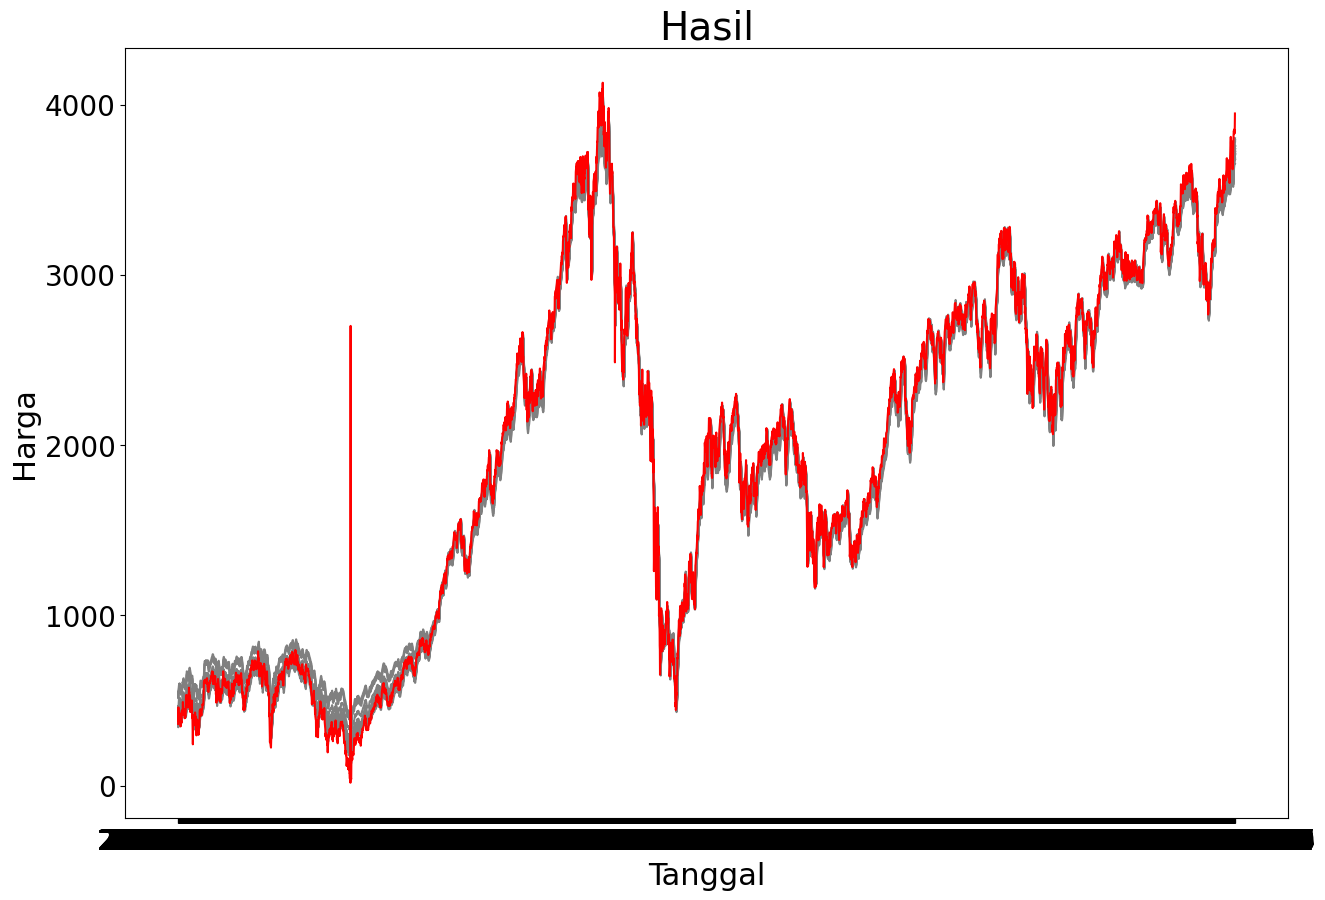

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in traincopy.columns:
  if column != 'Rata2':
    ax.plot(traincopy.index, traincopy[column], label='Prediksi', color='gray')
ax.plot(traincopy.index, y_train2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

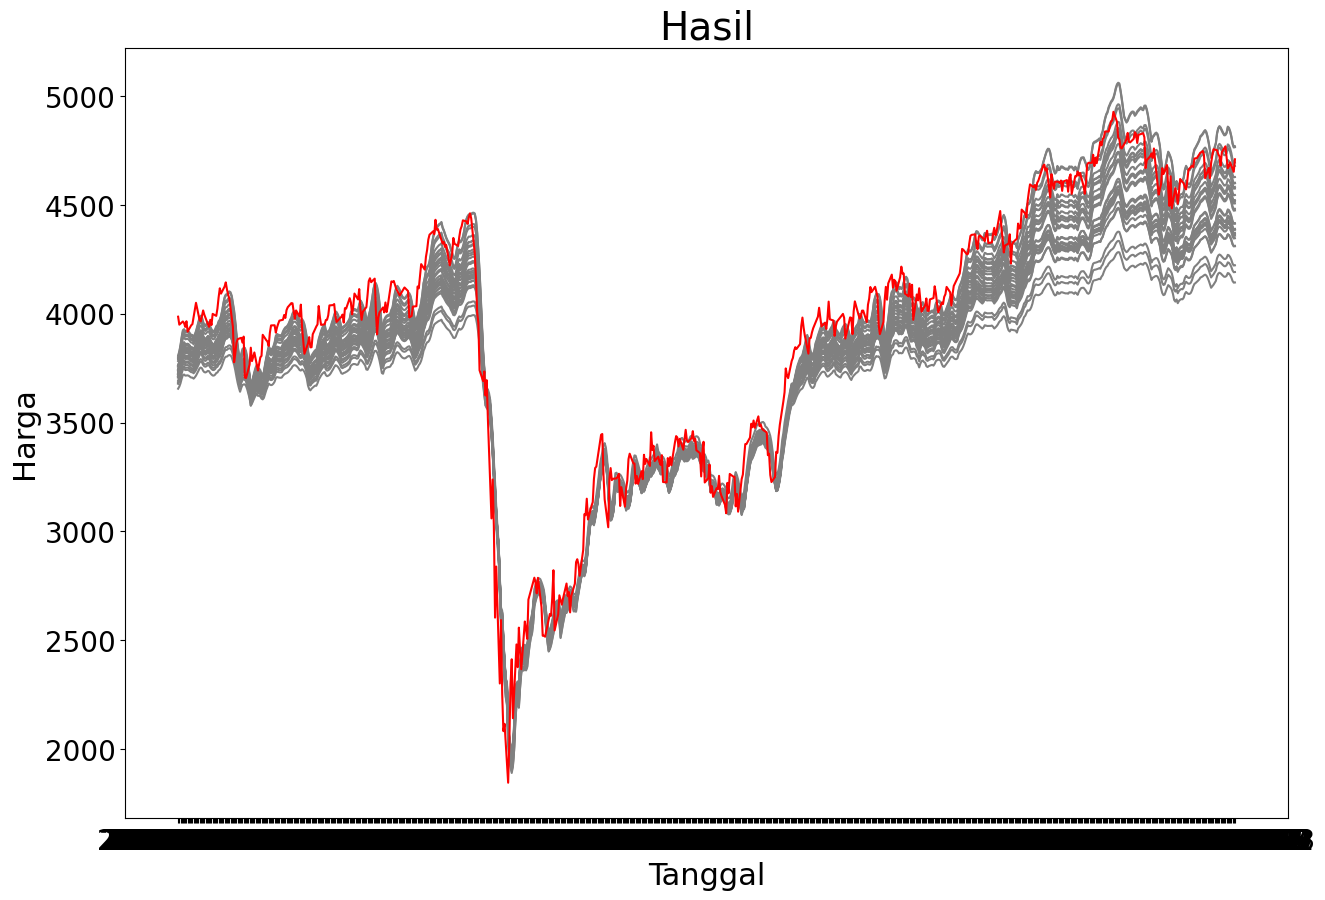

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in val_df.columns:
  if column != 'Rata2':
    ax.plot(val_df.index, val_df[column], label='Prediksi', color='gray')
ax.plot(val_df.index, y_val2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

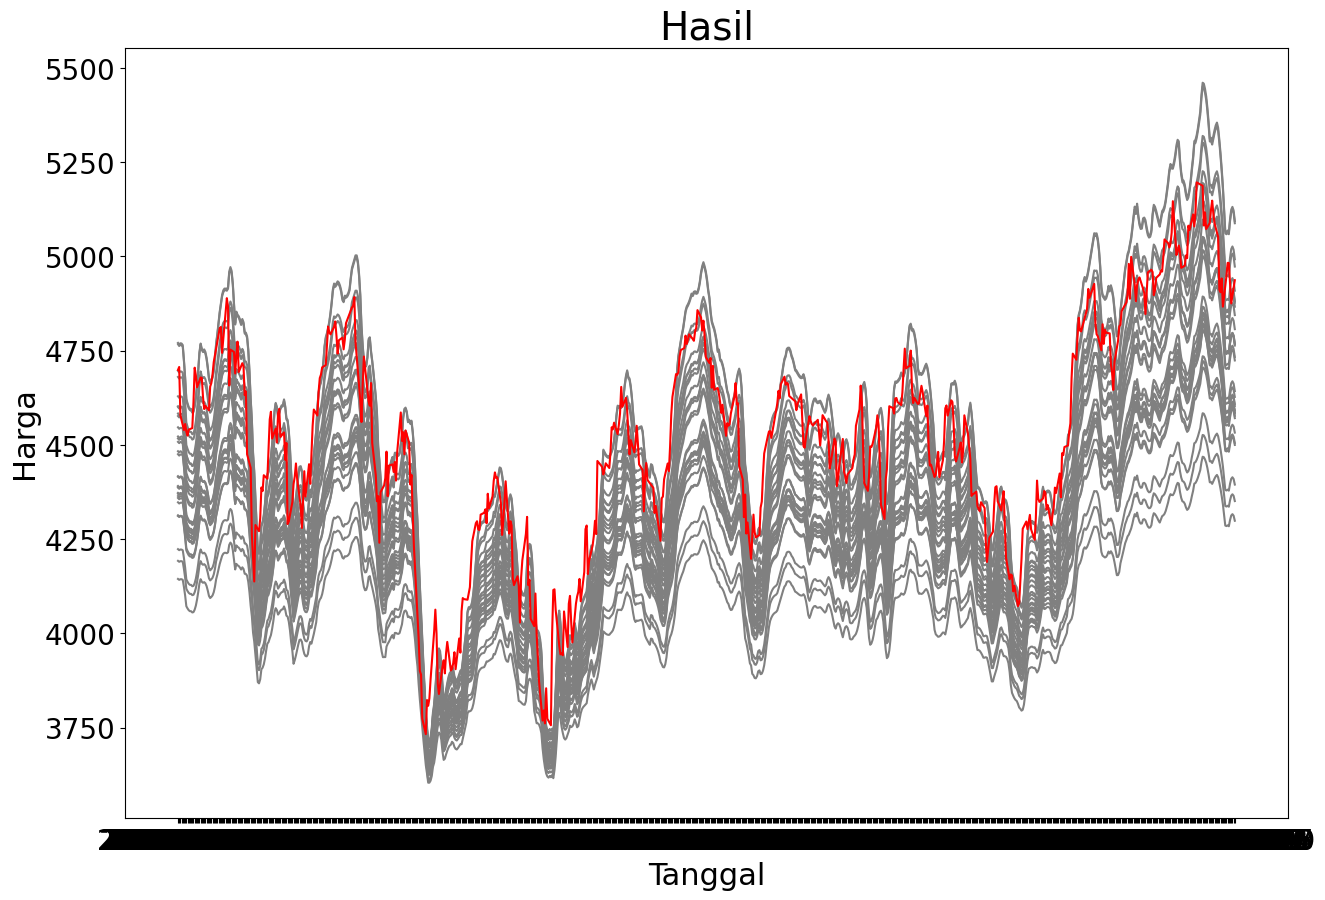

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in test_df.columns:
  if column != 'Rata2':
    ax.plot(test_df.index, test_df[column], label='Prediksi', color='gray')
ax.plot(test_df.index, y_test2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## Model Hybrid

In [ ]:
traincnn = train_df['Rata2']
valcnn = val_df['Rata2']
testcnn = test_df['Rata2']

traincnn = pd.DataFrame(traincnn)
valcnn = pd.DataFrame(valcnn)
testcnn = pd.DataFrame(testcnn)

traincnn.columns = ['Close']
valcnn.columns = ['Close']
testcnn.columns = ['Close']

traincnn = traincnn.divide(range_value)
valcnn = valcnn.divide(range_value)
testcnn = testcnn.divide(range_value)
traincnn.shape, valcnn.shape, testcnn.shape, df.shape

((7102, 1), (888, 1), (888, 1), (8883, 6))

In [ ]:
padding = traincnn[:2]
df = pd.concat([padding, traincnn, valcnn, testcnn])
df.reset_index(drop=True, inplace=True)
df

Close
0     0.078175
1     0.074903
2     0.078175
3     0.074903
4     0.075773
...        ...
8875  0.905624
8876  0.909137
8877  0.910183
8878  0.908858
8879  0.904903

[8880 rows x 1 columns]

In [ ]:
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_200']= df['Close'].ewm(span=200, adjust=False).mean()
df['Diff'] = df['EMA_50']-df['EMA_200']
df['sign'] = df['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
df['sign_change'] = df['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = df[df['sign_change']==1]

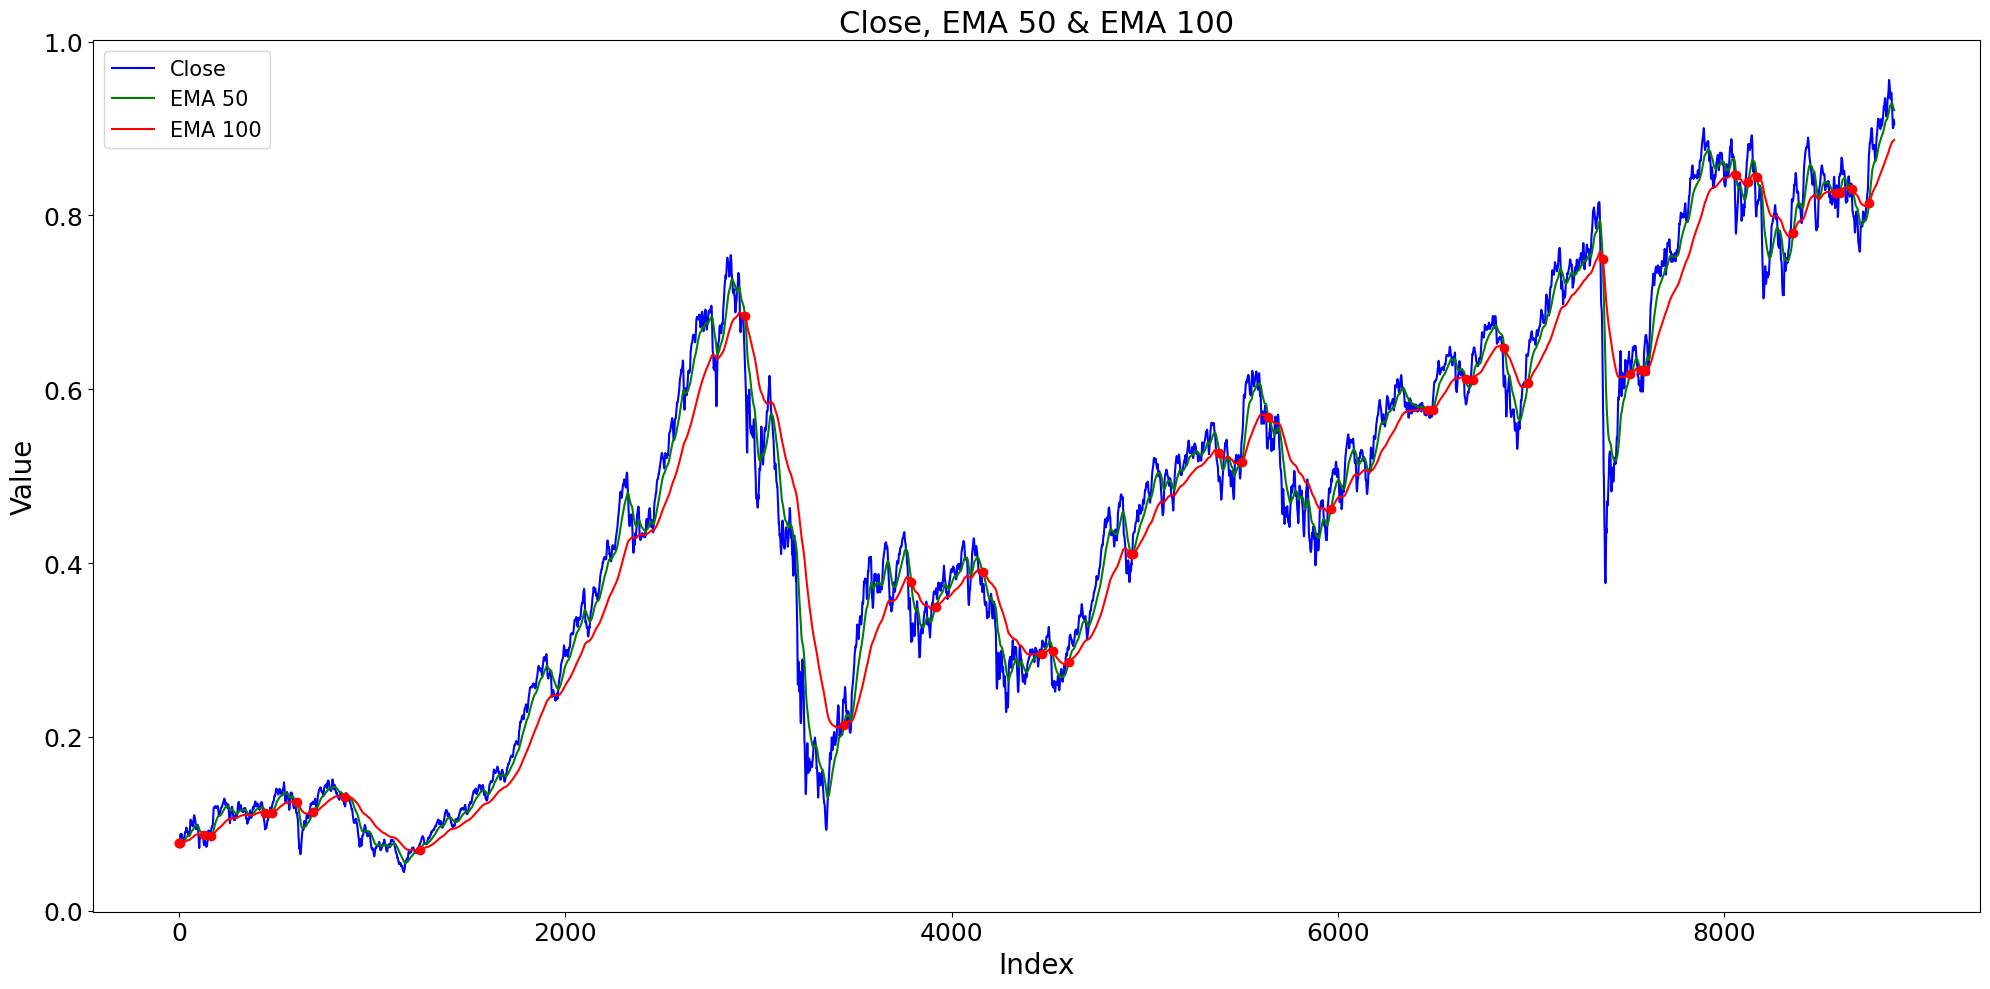

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(df['Close'], label='Close', color='blue')
plt.plot(df['EMA_50'], label='EMA50', color='green')
plt.plot(df['EMA_200'], label='EMA200', color='red')
plt.plot(idx1.index, df.loc[idx1.index, 'EMA_200'], 'ro', label='Sign Change')
plt.legend(['Close','EMA 50','EMA 100'], fontsize=15)
plt.title('Close, EMA 50 & EMA 100', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

## Data Buy Keep Sell


In [ ]:
df['label'] = df.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
df_buy_sell = df[df['label'] != 'Keep']
df_buy_sell

Close    EMA_50   EMA_200      Diff  sign  sign_change label
1     0.074903  0.078047  0.078142 -0.000096    -1            1   Buy
7     0.084638  0.078306  0.078199  0.000107     1            1  Sell
132   0.079052  0.086770  0.086882 -0.000112    -1            1   Buy
166   0.092319  0.086154  0.086141  0.000014     1            1  Sell
447   0.094558  0.112722  0.113033 -0.000311    -1            1   Buy
483   0.121679  0.112326  0.112045  0.000281     1            1  Sell
611   0.112597  0.124571  0.124751 -0.000179    -1            1   Buy
694   0.125511  0.113348  0.113124  0.000224     1            1  Sell
859   0.120545  0.130644  0.130943 -0.000298    -1            1   Buy
1249  0.077727  0.070237  0.070153  0.000084     1            1  Sell
2930  0.628860  0.683677  0.684213 -0.000537    -1            1   Buy
3444  0.241164  0.214160  0.213950  0.000210     1            1  Sell
3791  0.309279  0.376344  0.378032 -0.001688    -1            1   Buy
3918  0.366850  0.350449  0.350015  0.000433     1            1  Sell
4161  0.368932  0.389499  0.389621 -0.000122    -1            1   Buy
4468  0.308768  0.295813  0.295648  0.000166     1            1  Sell
4522  0.262596  0.298388  0.299006 -0.000618    -1            1   Buy
4607  0.303316  0.285812  0.285764  0.000048     1            1  Sell
4927  0.390921  0.410469  0.410989 -0.000520    -1            1   Buy
4940  0.433989  0.411444  0.411027  0.000417     1            1  Sell
5386  0.499478  0.526746  0.526799 -0.000053    -1            1   Buy
5504  0.546769  0.516973  0.516403  0.000570     1            1  Sell
5638  0.539848  0.567731  0.567868 -0.000136    -1            1   Buy
5963  0.489520  0.462094  0.462017  0.000077     1            1  Sell
6466  0.573426  0.576451  0.576474 -0.000023    -1            1   Buy
6494  0.596600  0.576740  0.576183  0.000557     1            1  Sell
6661  0.582904  0.611573  0.612351 -0.000778    -1            1   Buy
6696  0.640753  0.611198  0.610537  0.000661     1            1  Sell
6861  0.607058  0.646535  0.647711 -0.001176    -1            1   Buy
6983  0.639102  0.606973  0.606779  0.000194     1            1  Sell
7370  0.611933  0.749003  0.749922 -0.000919    -1            1   Buy
7513  0.627149  0.617709  0.617609  0.000101     1            1  Sell
7566  0.597488  0.621590  0.621763 -0.000173    -1            1   Buy
7587  0.650612  0.621189  0.621132  0.000056     1            1  Sell
8061  0.782093  0.845049  0.846635 -0.001586    -1            1   Buy
8124  0.880993  0.839471  0.838499  0.000972     1            1  Sell
8167  0.806998  0.844199  0.844352 -0.000153    -1            1   Buy
8357  0.819589  0.780749  0.780145  0.000605     1            1  Sell
8576  0.816591  0.826153  0.826187 -0.000034    -1            1   Buy
8580  0.831440  0.826398  0.826247  0.000151     1            1  Sell
8586  0.804486  0.825839  0.826134 -0.000295    -1            1   Buy
8596  0.844992  0.826208  0.826066  0.000141     1            1  Sell
8662  0.809223  0.830677  0.830730 -0.000054    -1            1   Buy
8749  0.871520  0.815539  0.814035  0.001504     1            1  Sell

In [ ]:
df['label1'] = df.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
df_buy_sell1 = df[df['label1'] != 0]
df_buy_sell1

Close    EMA_50   EMA_200      Diff  sign  sign_change label  label1
1     0.074903  0.078047  0.078142 -0.000096    -1            1   Buy       1
7     0.084638  0.078306  0.078199  0.000107     1            1  Sell      -1
132   0.079052  0.086770  0.086882 -0.000112    -1            1   Buy       1
166   0.092319  0.086154  0.086141  0.000014     1            1  Sell      -1
447   0.094558  0.112722  0.113033 -0.000311    -1            1   Buy       1
483   0.121679  0.112326  0.112045  0.000281     1            1  Sell      -1
611   0.112597  0.124571  0.124751 -0.000179    -1            1   Buy       1
694   0.125511  0.113348  0.113124  0.000224     1            1  Sell      -1
859   0.120545  0.130644  0.130943 -0.000298    -1            1   Buy       1
1249  0.077727  0.070237  0.070153  0.000084     1            1  Sell      -1
2930  0.628860  0.683677  0.684213 -0.000537    -1            1   Buy       1
3444  0.241164  0.214160  0.213950  0.000210     1            1  Sell      -1
3791  0.309279  0.376344  0.378032 -0.001688    -1            1   Buy       1
3918  0.366850  0.350449  0.350015  0.000433     1            1  Sell      -1
4161  0.368932  0.389499  0.389621 -0.000122    -1            1   Buy       1
4468  0.308768  0.295813  0.295648  0.000166     1            1  Sell      -1
4522  0.262596  0.298388  0.299006 -0.000618    -1            1   Buy       1
4607  0.303316  0.285812  0.285764  0.000048     1            1  Sell      -1
4927  0.390921  0.410469  0.410989 -0.000520    -1            1   Buy       1
4940  0.433989  0.411444  0.411027  0.000417     1            1  Sell      -1
5386  0.499478  0.526746  0.526799 -0.000053    -1            1   Buy       1
5504  0.546769  0.516973  0.516403  0.000570     1            1  Sell      -1
5638  0.539848  0.567731  0.567868 -0.000136    -1            1   Buy       1
5963  0.489520  0.462094  0.462017  0.000077     1            1  Sell      -1
6466  0.573426  0.576451  0.576474 -0.000023    -1            1   Buy       1
6494  0.596600  0.576740  0.576183  0.000557     1            1  Sell      -1
6661  0.582904  0.611573  0.612351 -0.000778    -1            1   Buy       1
6696  0.640753  0.611198  0.610537  0.000661     1            1  Sell      -1
6861  0.607058  0.646535  0.647711 -0.001176    -1            1   Buy       1
6983  0.639102  0.606973  0.606779  0.000194     1            1  Sell      -1
7370  0.611933  0.749003  0.749922 -0.000919    -1            1   Buy       1
7513  0.627149  0.617709  0.617609  0.000101     1            1  Sell      -1
7566  0.597488  0.621590  0.621763 -0.000173    -1            1   Buy       1
7587  0.650612  0.621189  0.621132  0.000056     1            1  Sell      -1
8061  0.782093  0.845049  0.846635 -0.001586    -1            1   Buy       1
8124  0.880993  0.839471  0.838499  0.000972     1            1  Sell      -1
8167  0.806998  0.844199  0.844352 -0.000153    -1            1   Buy       1
8357  0.819589  0.780749  0.780145  0.000605     1            1  Sell      -1
8576  0.816591  0.826153  0.826187 -0.000034    -1            1   Buy       1
8580  0.831440  0.826398  0.826247  0.000151     1            1  Sell      -1
8586  0.804486  0.825839  0.826134 -0.000295    -1            1   Buy       1
8596  0.844992  0.826208  0.826066  0.000141     1            1  Sell      -1
8662  0.809223  0.830677  0.830730 -0.000054    -1            1   Buy       1
8749  0.871520  0.815539  0.814035  0.001504     1            1  Sell      -1

In [ ]:
datacnn = df.copy()
datacnn = df[['Close','label1']]
datacnn

Close  label1
0     0.078175       0
1     0.074903       1
2     0.078175       0
3     0.074903       0
4     0.075773       0
...        ...     ...
8875  0.905624       0
8876  0.909137       0
8877  0.910183       0
8878  0.908858       0
8879  0.904903       0

[8880 rows x 2 columns]

In [ ]:
def windowed_df_close(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][0]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mq_80 = int(n_total2*0.8)
Mq_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mq_80], X_pred[:Mq_80], y_pred[:Mq_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mq_80:Mq_90],  X_pred[Mq_80:Mq_90], y_pred[Mq_80:Mq_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mq_90:],  X_pred[Mq_90:], y_pred[Mq_90:]

In [ ]:
datacnn

Close  label1
0     0.078175       0
1     0.074903       1
2     0.078175       0
3     0.074903       0
4     0.075773       0
...        ...     ...
8875  0.905624       0
8876  0.909137       0
8877  0.910183       0
8878  0.908858       0
8879  0.904903       0

[8880 rows x 2 columns]

In [ ]:
X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape

((7102, 2, 2), (888, 2, 2), (888, 2, 2), (888,))

In [ ]:
datafull2 = data_full.copy()
datafull2.index = datafull2['Date']
datafull2 = data_full['Close']
datafull2 = datafull2[3:]
datafull2 = datafull2.rename(columns={'^AXJO': 'Close'})

datafull2['EMA_50'] = datafull2['Close'].ewm(span=50, adjust=False).mean()
datafull2['EMA_200']= datafull2['Close'].ewm(span=200, adjust=False).mean()
datafull2['Diff'] = datafull2['EMA_50']-datafull2['EMA_200']
datafull2['sign'] = datafull2['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
datafull2['sign_change'] = datafull2['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = datafull2[datafull2['sign_change']==1]
datafull2['label'] = datafull2.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
datafull2_buy_sell = datafull2[datafull2['label'] != 'Keep']
datafull2['label1'] = datafull2.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
datafull2_buy_sell1 = datafull2[datafull2['label1'] != 0]

datafull2 = datafull2[['Close', 'label1']]
datafull2['Close'] = pd.to_numeric(datafull2['Close'])
datafull2['label1'] = pd.to_numeric(datafull2['label1'])

X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
datafull2

Ticker         Close  label1
Date                        
2000-01-07  0.062157       0
2000-01-08  0.066044      -1
2000-01-09  0.069932       0
2000-01-10  0.073819       0
2000-01-11  0.088598       0
...              ...     ...
2024-04-25  0.948533       0
2024-04-26  0.938228       0
2024-04-27  0.942173       0
2024-04-28  0.946118       0
2024-04-29  0.950063       0

[8880 rows x 2 columns]

## CNN HYPERPARAMETER TUNING

In [ ]:
!pip install keras-tuner -q

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_cnn_model(hp):
    model = Sequential()

    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same",
        input_shape=(2, 2)
    ))

    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_cnn',
    project_name='cnn_tuning_activation'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Menampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Filters: {best_hps.get('filters')}
- Activation (Conv1D): {best_hps.get('activation_conv')}
- Dense Layer Units: {best_hps.get('dense_units')}
- Activation (Dense): {best_hps.get('activation_dense')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 01m 00s]
val_loss: 0.0008081587729975581

Best val_loss So Far: 0.00045223208144307137
Total elapsed time: 00h 49m 29s

Best Hyperparameters:
- Filters: 64
- Activation (Conv1D): relu
- Dense Layer Units: 128
- Activation (Dense): tanh
- Dropout: 0.1
- Learning Rate: 0.001



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp

def build_cnn_model(hp):
    model = Sequential()
    model.add(Reshape((2, 2), input_shape=(2, 2)))
    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same"
    ))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model


bayesian_opt_tuner = BayesianOptimization(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='bayesian cnn',
    project_name='kerastuner_bayesian_cnn',
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Trial 60 Complete [00h 00m 47s]
val_loss: 0.0005867576692253351

Best val_loss So Far: 0.0004180373507551849
Total elapsed time: 00h 46m 16s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Best Hyperparameters:
filters: 32
activation_conv: relu
dense_units: 128
activation_dense: tanh
dropout: 0.2
learning_rate: 0.01


## CNN MODEL

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datacnn, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(64, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(128, activation="tanh"))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2, 64)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnrs_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0


 Model di iterasi ke-28 dengan MAPE = 0.0168


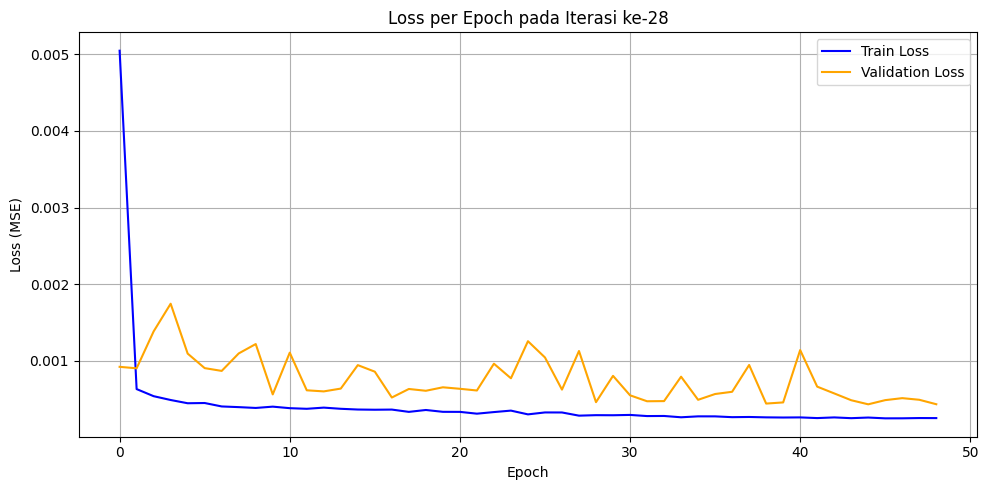

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.896252   0.900332   0.892766   0.897617   0.900955   0.901424   
2021-11-25   0.896403   0.900465   0.892902   0.897713   0.901064   0.901549   
2021-11-26   0.895688   0.899512   0.892058   0.896446   0.899832   0.900599   
2021-11-27   0.896177   0.900329   0.892740   0.897733   0.901045   0.901434   
2021-11-28   0.896159   0.900169   0.892632   0.897353   0.900707   0.901257   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.941760   0.946887   0.937603   0.942485   0.947769   0.946101   
2024-04-26   0.946870   0.953617   0.943584   0.951329   0.956409   0.952800   
2024-04-27   0.950783   0.957267   0.947217   0.954293   0.959663   0.956264   
2024-04-28   0.952048   0.957912   0.948054   0.953899   0.959520   0.956778   
2024-04-29   0.950715   0.955914   0.946341   0.950976   0.956723   0.954744   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_AUSTRALIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnrs_AUSTRALIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnrs_AUSTRALIA.csv')
bm_train_predictions.to_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
bm_val_predictions.to_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')


In [ ]:
!zip -r cnnrs_weights.zip /content/cnnrs_weights
from google.colab import files
files.download("cnnrs_weights.zip")

  adding: content/cnnrs_weights/ (stored 0%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 16%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_23.weights.h5 (deflated 16%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_4.weights.h5 (deflated 17%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_1.weights.h5 (deflated 16%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 16%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_20.weights.h5 (deflated 16%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_10.weights.h5 (deflated 18%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_21.weights.h5 (deflated 18%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 17%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_7.weights.h5 (deflated 17%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_3.weights.h5 (deflated 16%)
  adding: content/cnnrs_w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

51.63699650565285 5359.006910024177 73.20523826902128 68192561294519.14
77.02773612540754 12503.385750492647 111.81853938633185 0.02198488199888288
77.91459850964236 9626.416550580348 98.11430349638297 0.017496349094213205


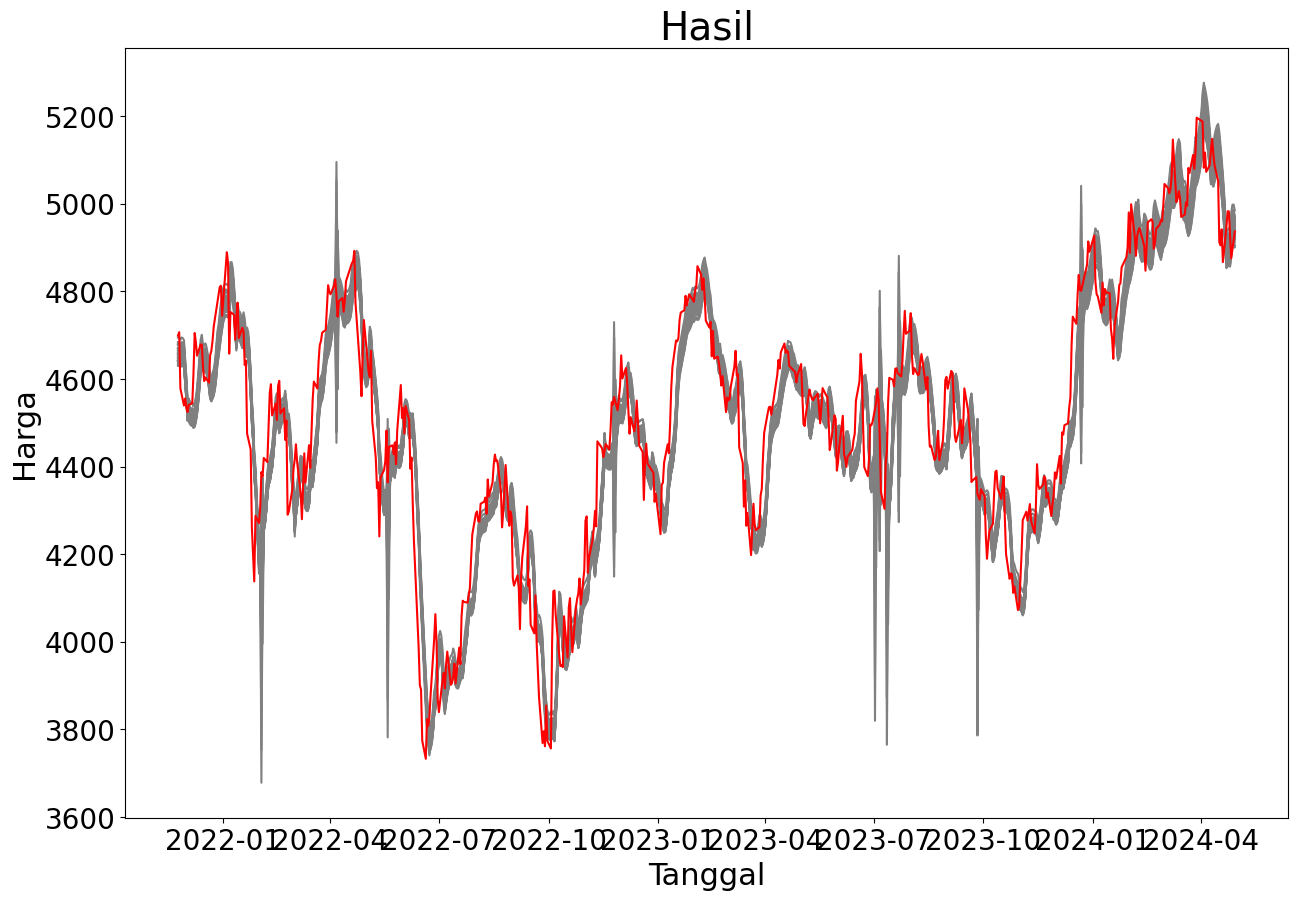

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

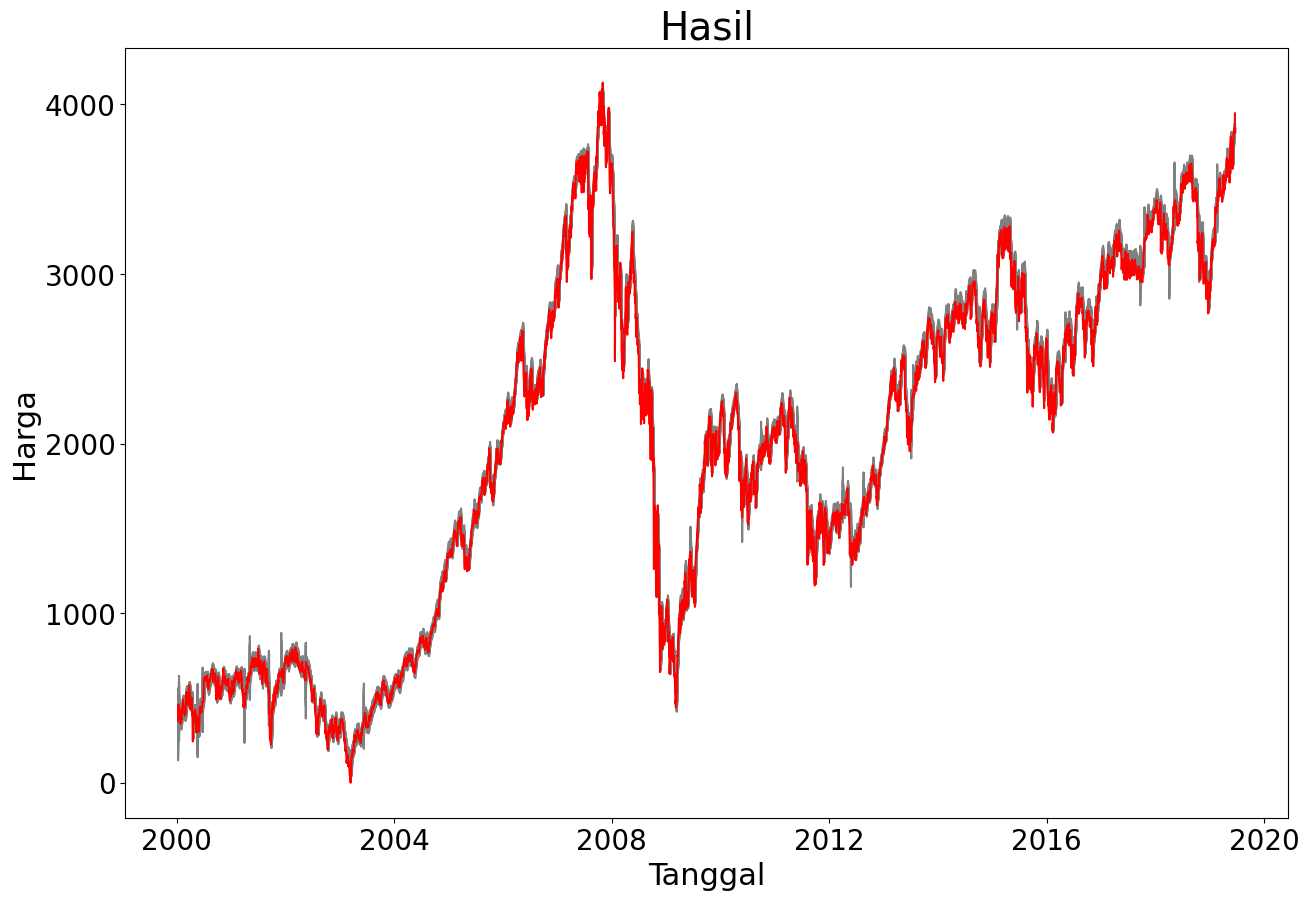

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## CNN dengan Bayesian

In [ ]:
X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mqn_80], X_pred[:Mqn_80], y_pred[:Mqn_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mqn_80:Mqn_90],  X_pred[Mqn_80:Mqn_90], y_pred[Mqn_80:Mqn_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mqn_90:],  X_pred[Mqn_90:], y_pred[Mqn_90:]
print(X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape)
print(y_pred_train.shape, y_pred_val.shape, y_pred_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(32, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(128, activation="tanh"))
cnn.add(Dropout(0.2))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 32)          │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,609 (33.63 KB)

 Trainable params: 8,609 (33.63 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnbo_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-11 dengan MAPE = 0.0165


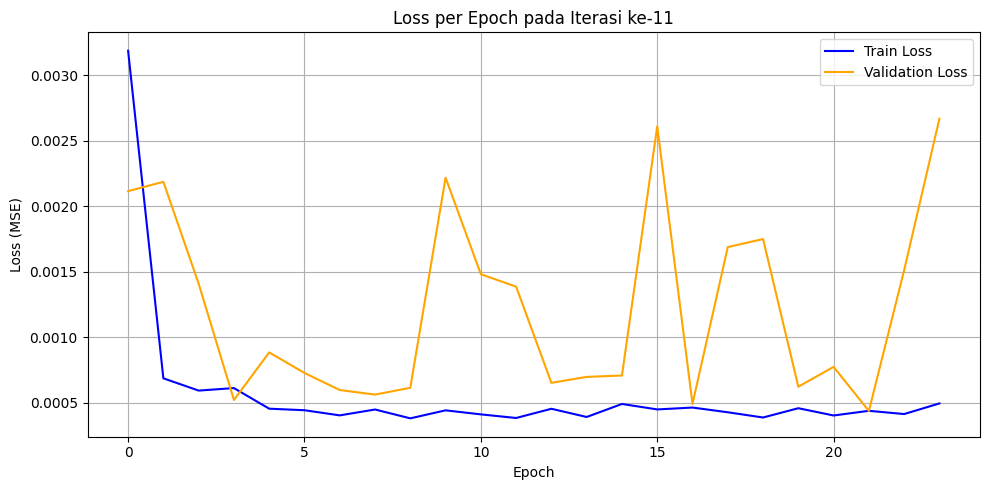

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.895852   0.902103   0.898873   0.890796   0.895421   0.897990   
2021-11-25   0.895964   0.902273   0.899037   0.890968   0.895554   0.898153   
2021-11-26   0.894709   0.901522   0.898458   0.890544   0.894670   0.897536   
2021-11-27   0.895942   0.902007   0.898753   0.890633   0.895406   0.897879   
2021-11-28   0.895600   0.902012   0.898822   0.890789   0.895275   0.897929   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.943742   0.952529   0.944250   0.934867   0.940374   0.943867   
2024-04-26   0.952503   0.957943   0.948433   0.937999   0.946611   0.948299   
2024-04-27   0.955818   0.962394   0.952547   0.942214   0.950192   0.952406   
2024-04-28   0.955686   0.963941   0.954200   0.944220   0.950925   0.953986   
2024-04-29   0.952853   0.962578   0.953256   0.943697   0.949106   0.952945   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_AUSTRALIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

bm_prediction_df.to_csv('hasilprediksicnnbo_AUSTRALIA.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_AUSTRALIA.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_AUSTRALIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnbo_AUSTRALIA.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_AUSTRALIA.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_AUSTRALIA.csv')


In [ ]:
!zip -r cnnbo_weights.zip /content/cnnbo_weights
from google.colab import files
files.download("cnnbo_weights.zip")

  adding: content/cnnbo_weights/ (stored 0%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 26%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_23.weights.h5 (deflated 28%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_4.weights.h5 (deflated 24%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_1.weights.h5 (deflated 28%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 27%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_20.weights.h5 (deflated 26%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_10.weights.h5 (deflated 26%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_21.weights.h5 (deflated 26%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 27%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_7.weights.h5 (deflated 30%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_3.weights.h5 (deflated 27%)
  adding: content/cnnbo_w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

55.05806007145336 5691.409279422463 75.44142946301099 69040504677341.71
78.69880181389878 13271.482418096473 115.20192020142925 0.022565063543441587
78.79643618838558 9960.008813264862 99.79984375370967 0.017717860154065256


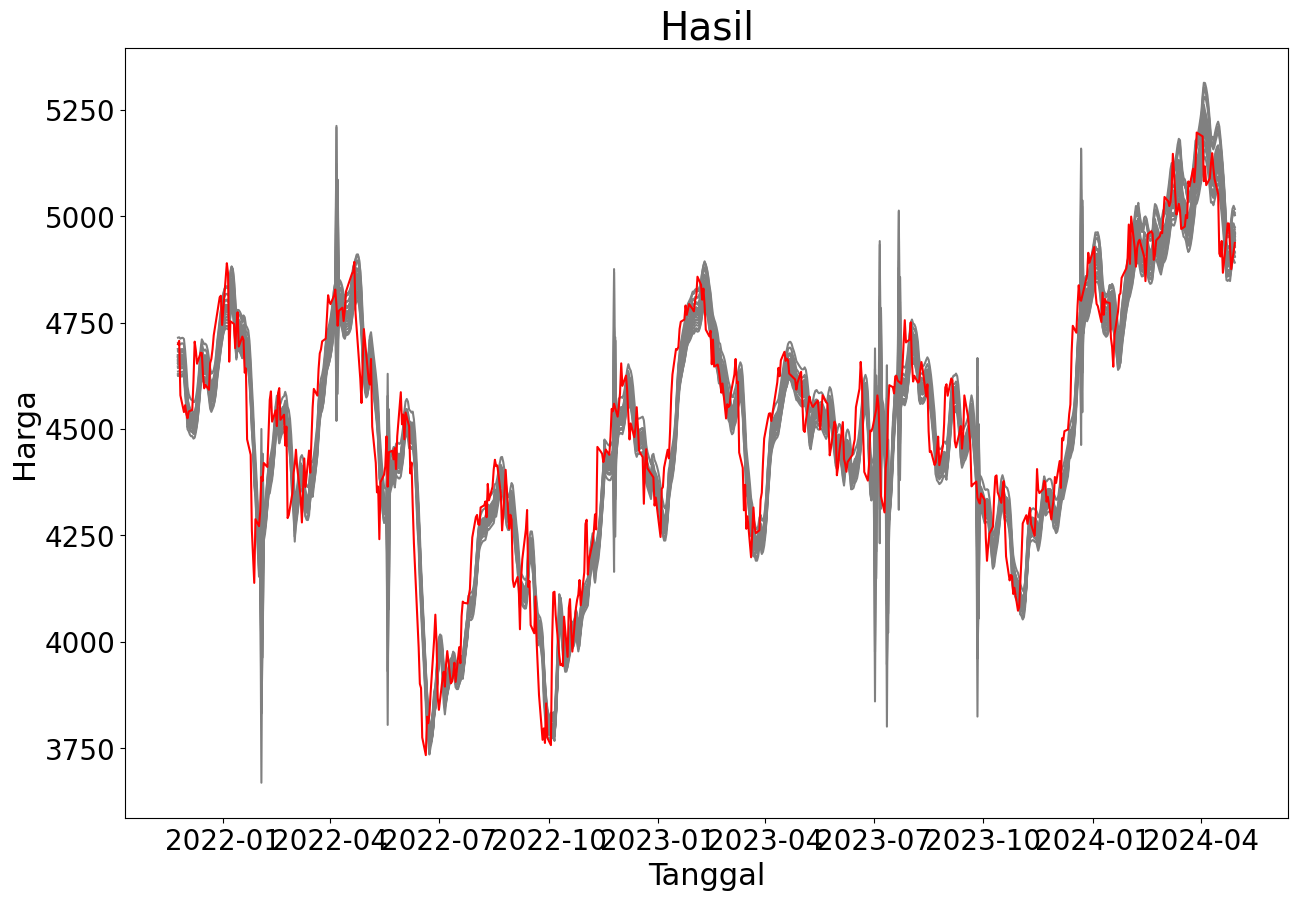

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

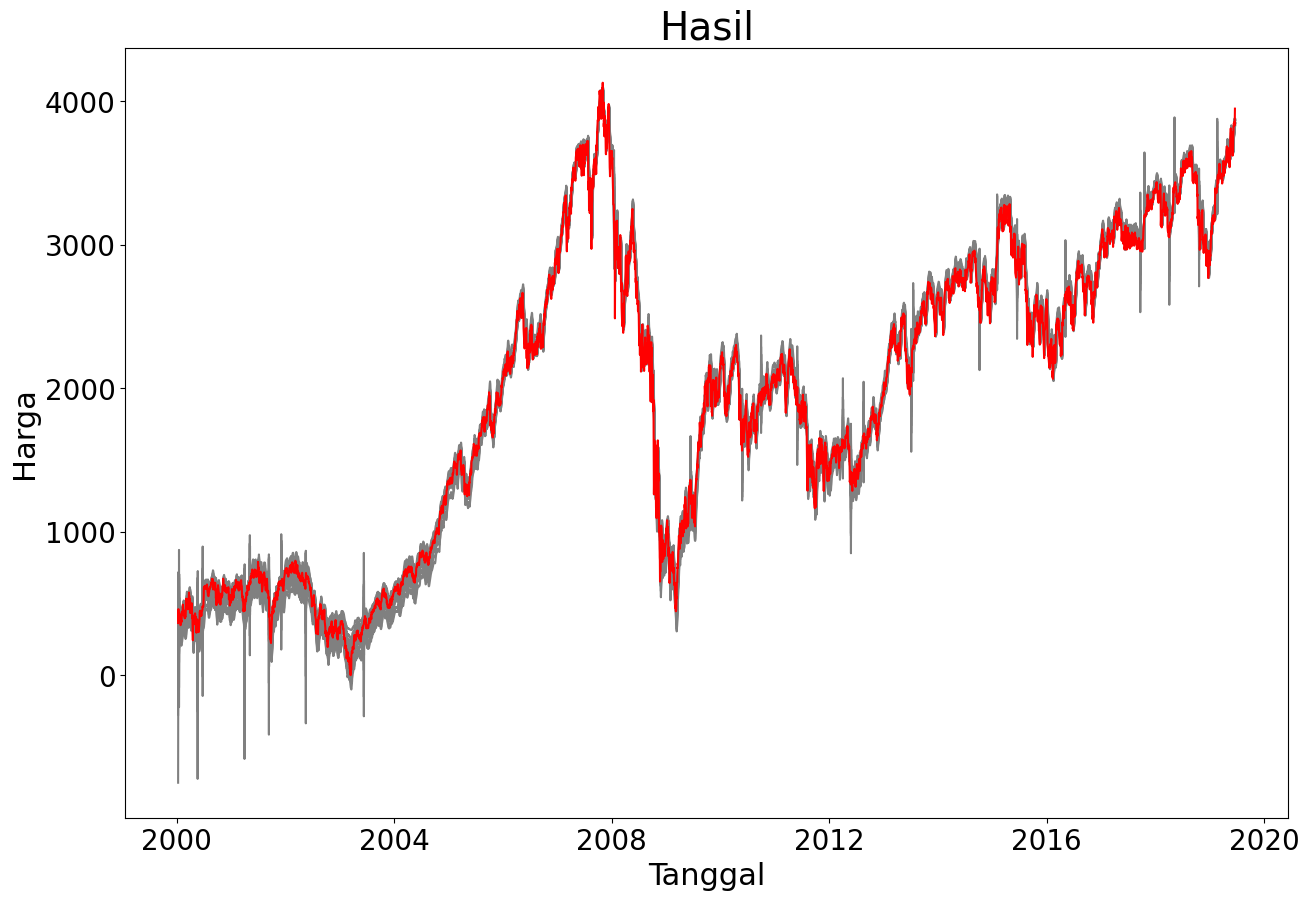

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2,2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_ann',
    project_name='ann_tuning'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Dense Layer 1 Units: {best_hps.get('dense_units_1')}
- Activation 1: {best_hps.get('activation_1')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 01m 16s]
val_loss: 0.0015726004494354129

Best val_loss So Far: 0.0005370244616642594
Total elapsed time: 00h 45m 49s

Best Hyperparameters:
- Dense Layer 1 Units: 64
- Activation 1: sigmoid
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp
def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2, 2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_ann_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_ann_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 00m 32s]
val_loss: 0.0005784828681498766

Best val_loss So Far: 0.0005332553409971297
Total elapsed time: 00h 47m 32s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
dense_units_1: 64
activation_1: sigmoid
dropout: 0.1
learning_rate: 0.01


In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(64, activation='sigmoid'))
ann.add(Dropout(0.1))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annrs_weights/best_annrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-8 dengan MAPE = 0.0182


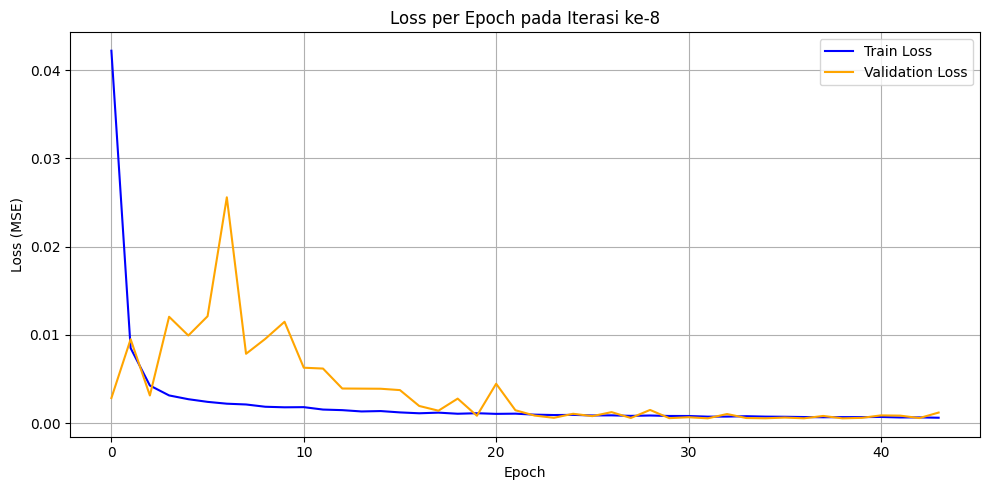

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.905448   0.906553   0.902632   0.904666   0.912755   0.906986   
2021-11-25   0.905642   0.906751   0.902826   0.904857   0.912953   0.907196   
2021-11-26   0.905311   0.906419   0.902502   0.904544   0.912611   0.906844   
2021-11-27   0.905233   0.906334   0.902416   0.904452   0.912538   0.906752   
2021-11-28   0.905478   0.906585   0.902663   0.904699   0.912784   0.907019   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.951327   0.953234   0.948482   0.949459   0.959590   0.956933   
2024-04-26   0.953720   0.955653   0.950840   0.951714   0.962069   0.959531   
2024-04-27   0.958142   0.960177   0.955284   0.956031   0.966587   0.964410   
2024-04-28   0.960482   0.962580   0.957648   0.958336   0.968969   0.967006   
2024-04-29   0.960281   0.962385   0.957464   0.958172   0.968751   0.966799   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_AUSTRALIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_AUSTRALIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_AUSTRALIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_AUSTRALIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannrs_AUSTRALIA.csv')
bm_train_predictions.to_csv('hasilprediksiannrs_train_AUSTRALIA.csv')
bm_val_predictions.to_csv('hasilprediksiannrs_val_AUSTRALIA.csv')


In [ ]:
!zip -r annrs_weights.zip /content/annrs_weights
from google.colab import files
files.download("annrs_weights.zip")

  adding: content/annrs_weights/ (stored 0%)
  adding: content/annrs_weights/best_annrs_weights_iter_10.weights.h5 (deflated 79%)
  adding: content/annrs_weights/best_annrs_weights_iter_1.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_15.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_29.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_18.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_23.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_24.weights.h5 (deflated 79%)
  adding: content/annrs_weights/best_annrs_weights_iter_26.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_5.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_27.weights.h5 (deflated 78%)
  adding: content/annrs_weights/best_annrs_weights_iter_12.weights.h5 (deflated 78%)
  adding: content/annr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

57.946841351240494 6482.728687281396 80.51539410126114 89776306824139.27
80.79377865719717 14422.455981600104 120.09353014047053 0.0232503776598121
81.14903956691066 11169.698248443265 105.68679315999357 0.0183135217221352


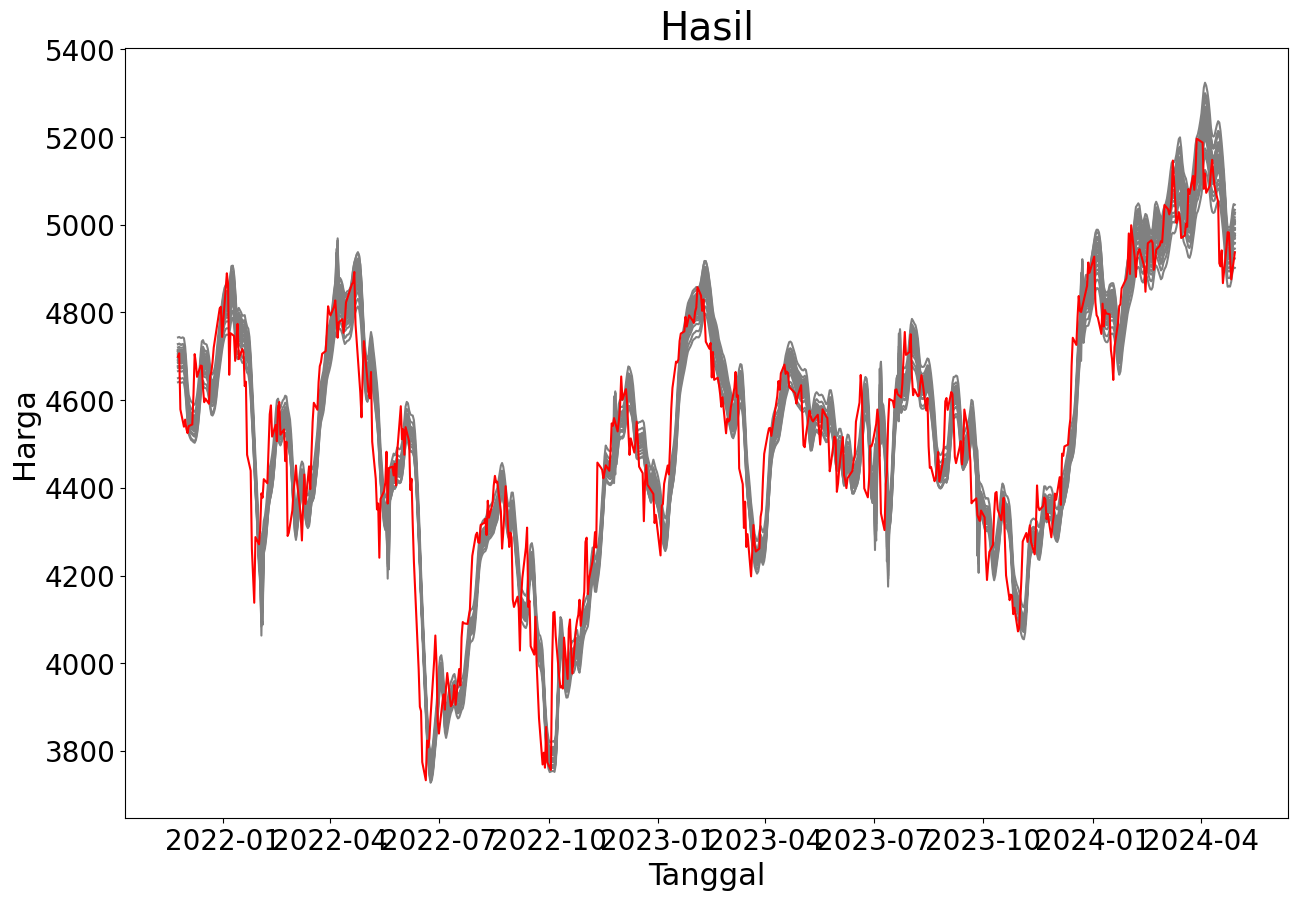

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

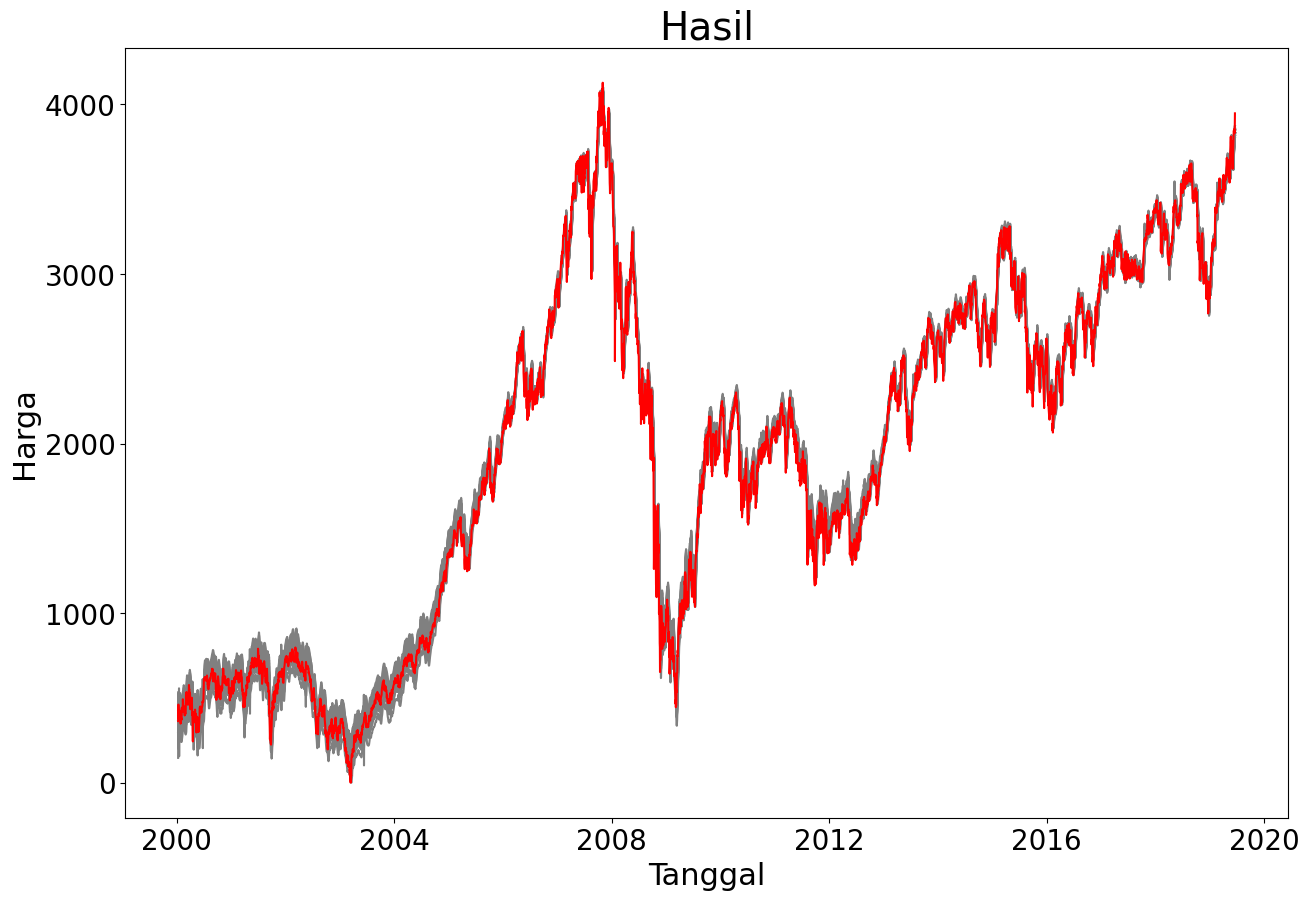

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN dengan Bayesian sama

In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(32, activation='sigmoid'))
ann.add(Dropout(0.2))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annbo_weights/best_annbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-28 dengan MAPE = 0.0179


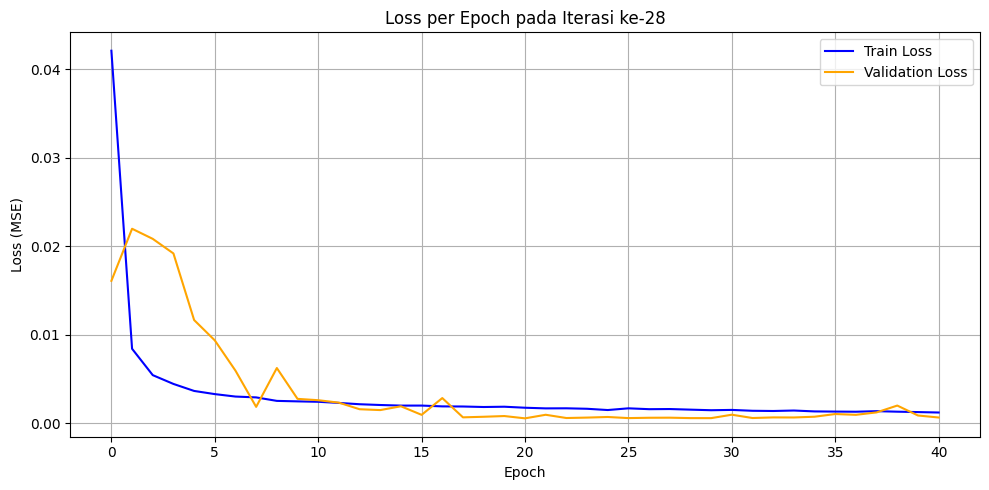

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.904814   0.895700   0.908803   0.902328   0.906679   0.901214   
2021-11-25   0.905004   0.895873   0.908987   0.902502   0.906858   0.901389   
2021-11-26   0.904689   0.895599   0.908675   0.902227   0.906551   0.901101   
2021-11-27   0.904601   0.895504   0.908600   0.902131   0.906482   0.901020   
2021-11-28   0.904845   0.895732   0.908832   0.902360   0.906706   0.901243   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.948835   0.935337   0.951278   0.941553   0.947463   0.941009   
2024-04-26   0.951032   0.937239   0.953436   0.943402   0.949524   0.942970   
2024-04-27   0.955188   0.940976   0.957422   0.947034   0.953278   0.946675   
2024-04-28   0.957397   0.942980   0.959526   0.948977   0.955248   0.948640   
2024-04-29   0.957232   0.942860   0.959349   0.948862   0.955073   0.948493   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_AUSTRALIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_AUSTRALIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_AUSTRALIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_AUSTRALIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannbo_AUSTRALIA.csv')
bm_train_predictions.to_csv('hasilprediksiannbo_train_AUSTRALIA.csv')
bm_val_predictions.to_csv('hasilprediksiannbo_val_AUSTRALIA.csv')


In [ ]:
!zip -r annbo_weights.zip /content/annbo_weights
from google.colab import files
files.download("annbo_weights.zip")

  adding: content/annbo_weights/ (stored 0%)
  adding: content/annbo_weights/best_annbo_weights_iter_21.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_23.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_29.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_5.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_13.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_28.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_6.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_18.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_20.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_8.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_3.weights.h5 (deflated 86%)
  adding: content/annbo_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

68.46731846558438 8280.746268229925 90.9986058587159 76179091080972.1
80.1486385677669 14293.570948567078 119.55572319453 0.023134191887677756
79.2104400543121 10631.811146030786 103.11067425844323 0.017885243728659593


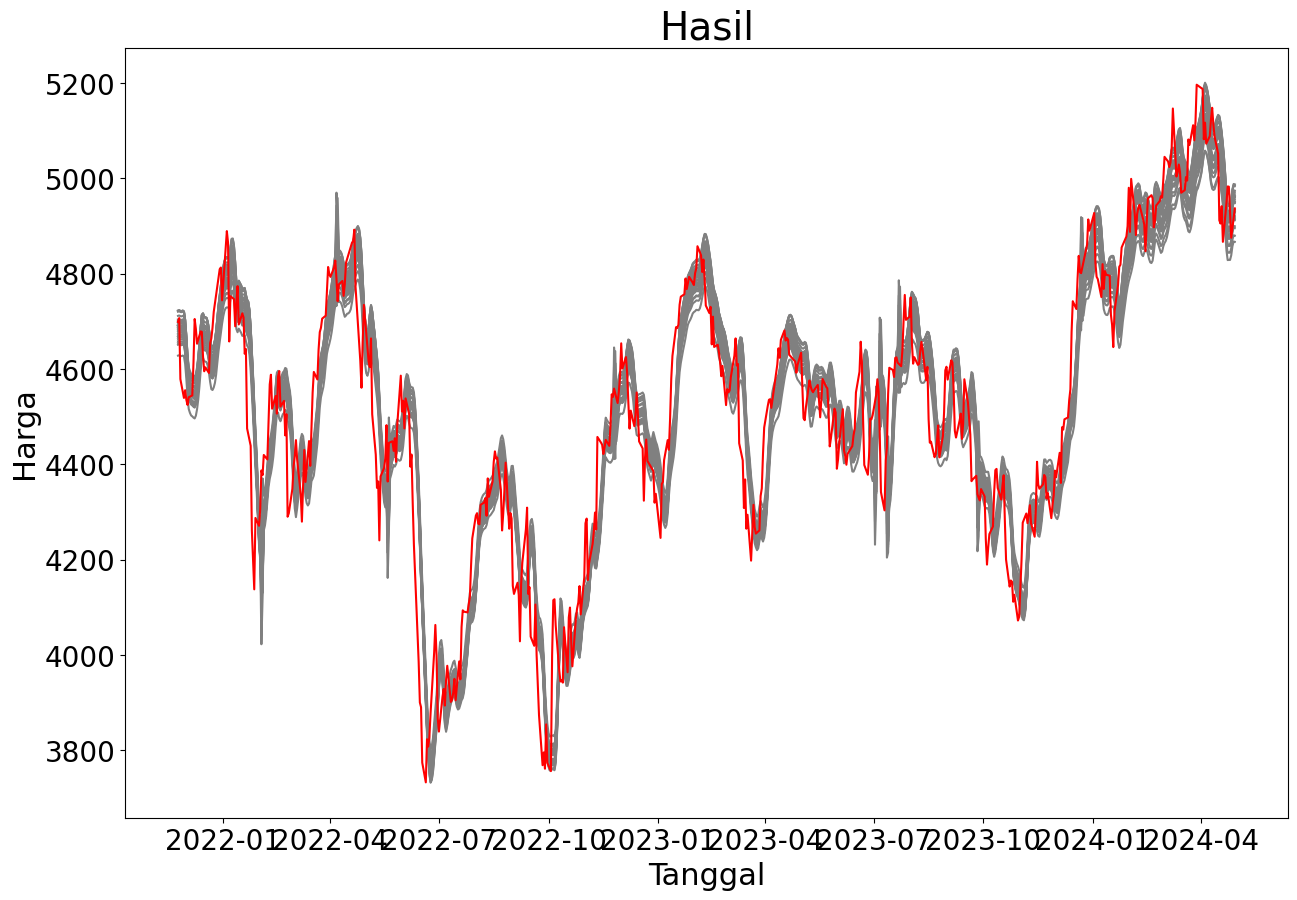

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

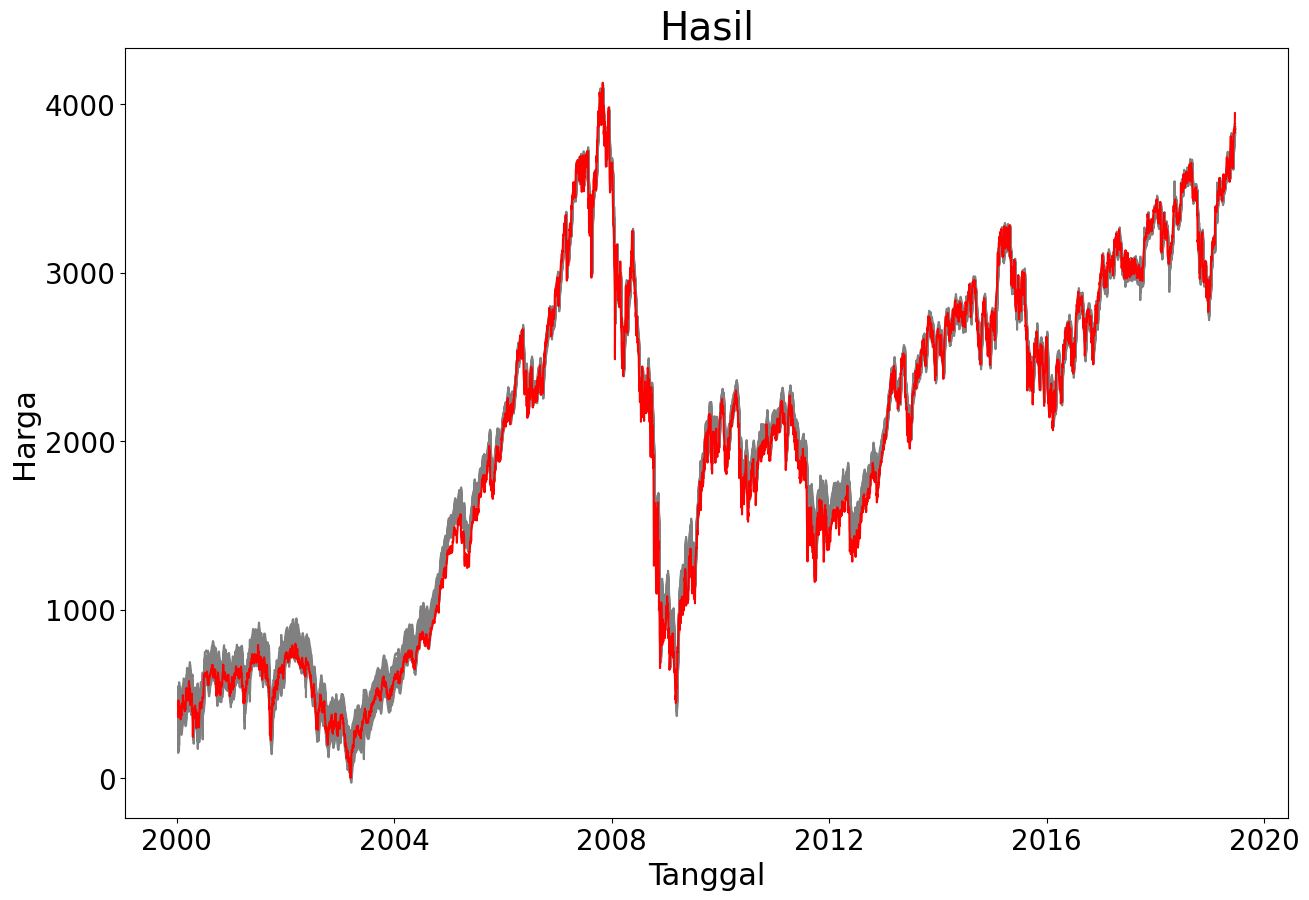

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import SimpleRNN
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_rnn',
    project_name='rnn_tuning'
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- RNN Units: {best_hps.get('rnn_units')}
- Activation: {best_hps.get('activation')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 01m 10s]
val_loss: 0.0005880235112272203

Best val_loss So Far: 0.0005447468720376492
Total elapsed time: 00h 53m 10s

Best Hyperparameters:
- RNN Units: 64
- Activation: relu
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
best_rnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_rnn_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 00m 33s]
val_loss: 0.0005457510123960674

Best val_loss So Far: 0.0005356326000764966
Total elapsed time: 00h 41m 03s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
rnn_units: 16
activation: sigmoid
dropout: 0.1
learning_rate: 0.01


In [ ]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
rnn = Sequential()
rnn.add(SimpleRNN(64, activation='relu', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.1))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnrs_weights/best_rnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-2 dengan MAPE = 0.0181


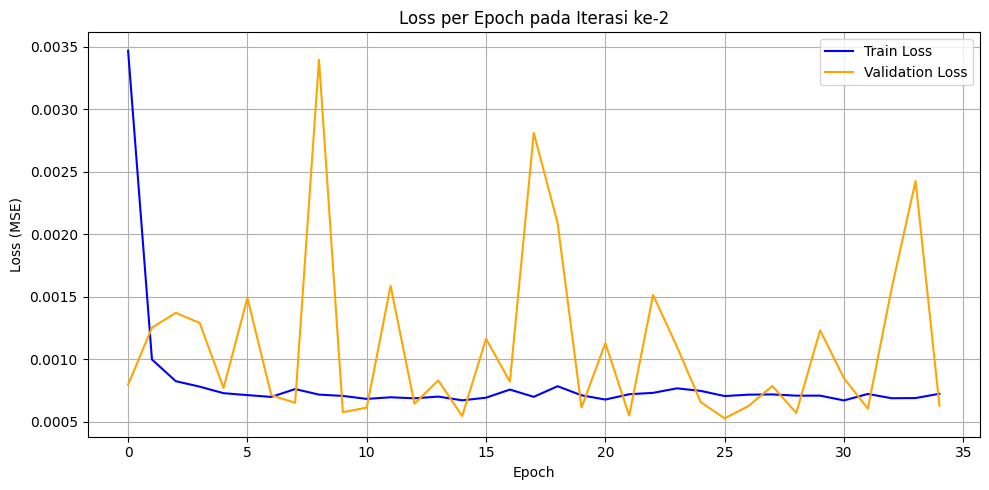

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.901916   0.901263   0.888696   0.900922   0.893579   0.894496   
2021-11-25   0.902105   0.901438   0.888876   0.901123   0.893764   0.894682   
2021-11-26   0.901693   0.900940   0.888547   0.900734   0.893372   0.894271   
2021-11-27   0.901725   0.901109   0.888500   0.900709   0.893391   0.894310   
2021-11-28   0.901922   0.901239   0.888718   0.900941   0.893588   0.894501   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.949433   0.947627   0.933112   0.950493   0.939799   0.941585   
2024-04-26   0.952513   0.951283   0.935605   0.953427   0.942732   0.944653   
2024-04-27   0.957133   0.955637   0.940039   0.958312   0.947240   0.949229   
2024-04-28   0.959428   0.957596   0.942404   0.960827   0.949500   0.951498   
2024-04-29   0.958989   0.956893   0.942172   0.960487   0.949101   0.951057   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_AUSTRALIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_AUSTRALIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_AUSTRALIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_AUSTRALIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnrs_AUSTRALIA.csv')
bm_train_predictions.to_csv('hasilprediksirnnrs_train_AUSTRALIA.csv')
bm_val_predictions.to_csv('hasilprediksirnnrs_val_AUSTRALIA.csv')


In [ ]:
!zip -r rnnrs_weights.zip /content/rnnrs_weights
from google.colab import files
files.download("rnnrs_weights.zip")

  adding: content/rnnrs_weights/ (stored 0%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_30.weights.h5 (deflated 44%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_20.weights.h5 (deflated 40%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_19.weights.h5 (deflated 40%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_7.weights.h5 (deflated 45%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_4.weights.h5 (deflated 41%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_18.weights.h5 (deflated 40%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_8.weights.h5 (deflated 39%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_15.weights.h5 (deflated 44%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_14.weights.h5 (deflated 42%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_11.weights.h5 (deflated 40%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_1.weights.h5 (deflated 40%)
  adding: content/rnnrs_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

57.01592404767027 6364.084376491888 79.7752115415051 110182914423235.62
80.17441345764705 14421.64262497481 120.09014374616598 0.023118987126268687
80.9031335779138 10717.292146192698 103.52435532855395 0.018210919024586755


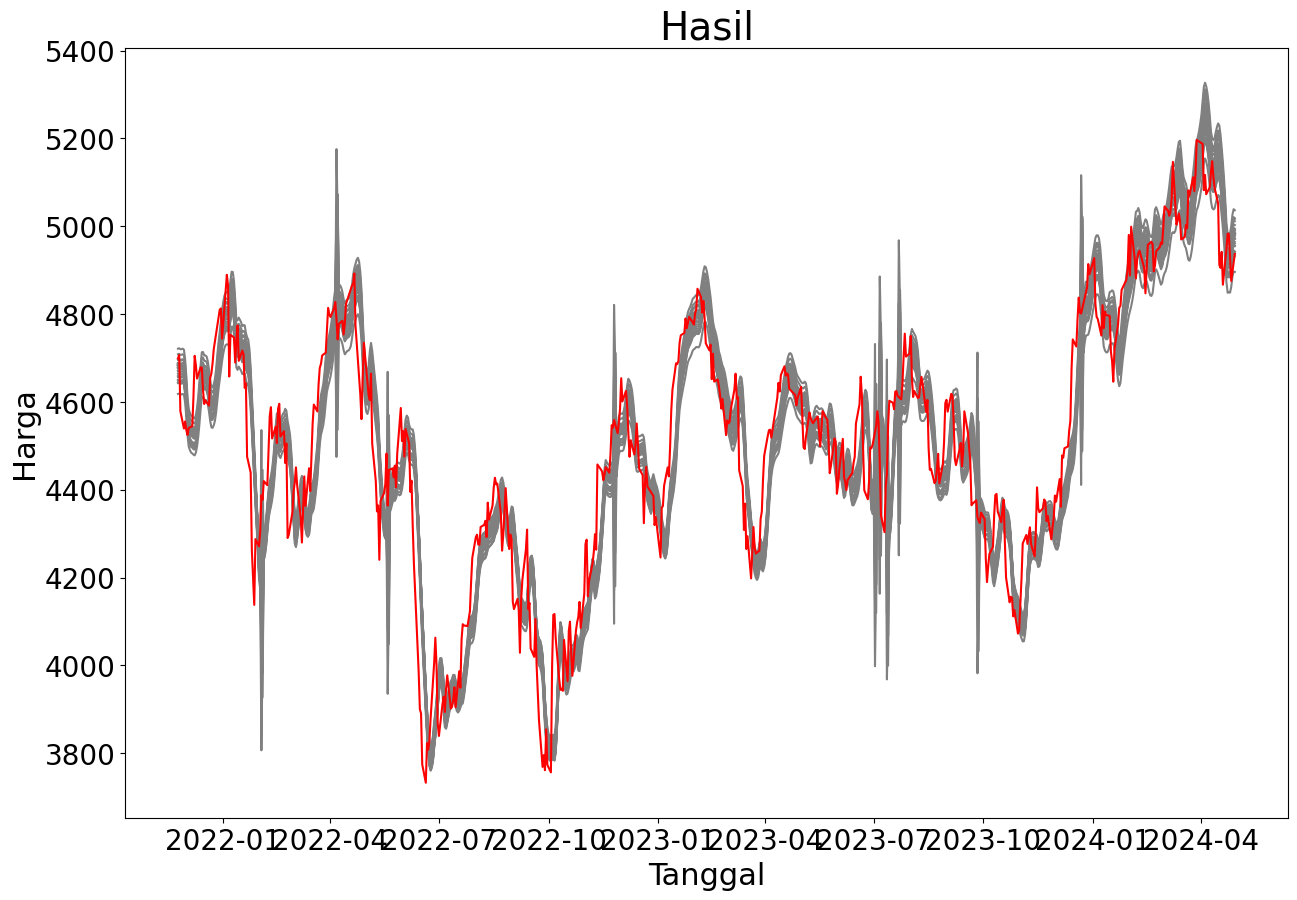

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

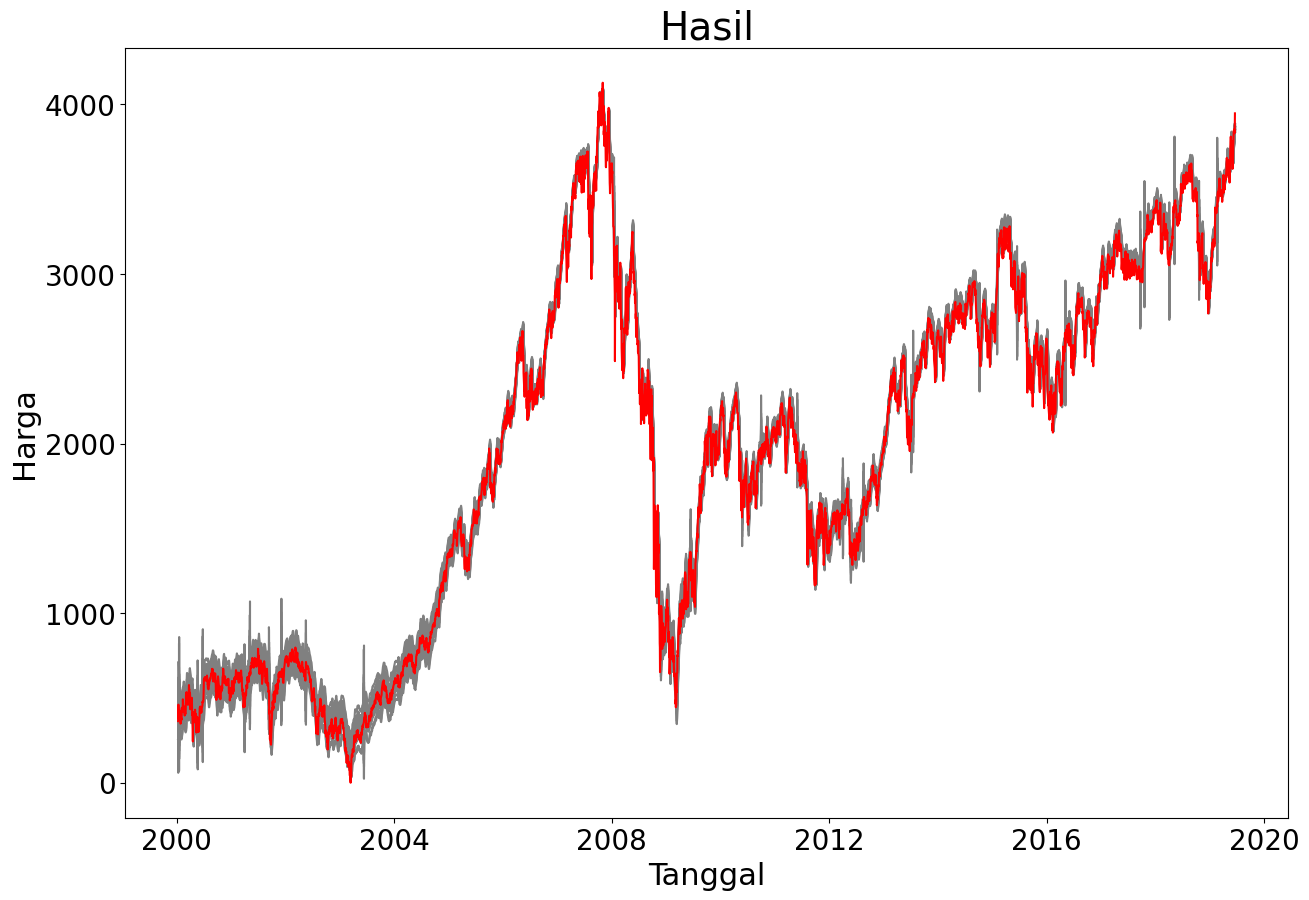

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN dengan Bayesian

In [ ]:
from tensorflow.keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(16, activation='sigmoid', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.1))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 16)             │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnbo_weights/best_rnnbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-28 dengan MAPE = 0.0177


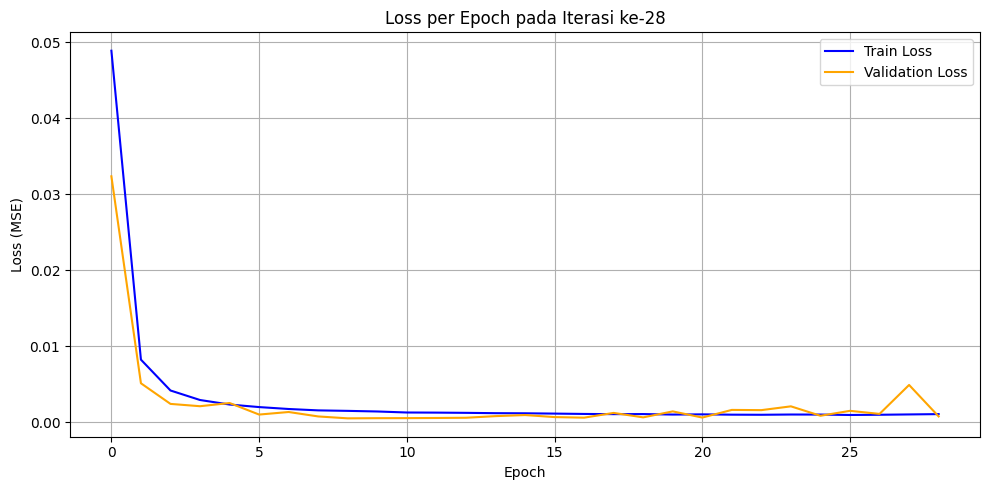

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.900701   0.899798   0.908147   0.895050   0.896600   0.899022   
2021-11-25   0.900881   0.899976   0.908343   0.895227   0.896763   0.899205   
2021-11-26   0.900452   0.899528   0.907991   0.894864   0.896445   0.898871   
2021-11-27   0.900527   0.899629   0.907933   0.894867   0.896427   0.898822   
2021-11-28   0.900698   0.899789   0.908172   0.895062   0.896615   0.899045   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.946022   0.944941   0.955158   0.938198   0.935750   0.943147   
2024-04-26   0.949182   0.948200   0.957864   0.940969   0.938104   0.945737   
2024-04-27   0.953443   0.952380   0.962396   0.945065   0.941790   0.949988   
2024-04-28   0.955465   0.954319   0.964718   0.947075   0.943636   0.952152   
2024-04-29   0.954937   0.953740   0.964402   0.946663   0.943324   0.951834   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_AUSTRALIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_AUSTRALIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_AUSTRALIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_AUSTRALIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_AUSTRALIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_AUSTRALIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnbo_AUSTRALIA.csv')
bm_train_predictions.to_csv('hasilprediksirnnbo_train_AUSTRALIA.csv')
bm_val_predictions.to_csv('hasilprediksirnnbo_val_AUSTRALIA.csv')


In [ ]:
!zip -r rnnbo_weights.zip /content/rnnbo_weights
from google.colab import files
files.download("rnnbo_weights.zip")

  adding: content/rnnbo_weights/ (stored 0%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_8.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_23.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_4.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_28.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_19.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_22.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_9.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_15.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_11.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_18.weights.h5 (deflated 80%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_10.weights.h5 (deflated 80%)
  adding: content/rnnbo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

62.98834549923991 7093.945290922727 84.2255619804506 95965752626213.83
80.99868609454172 14538.468636232741 120.57557230315244 0.023433222376265418
79.04257614548139 10450.461809231452 102.22750025913503 0.017834640667920905


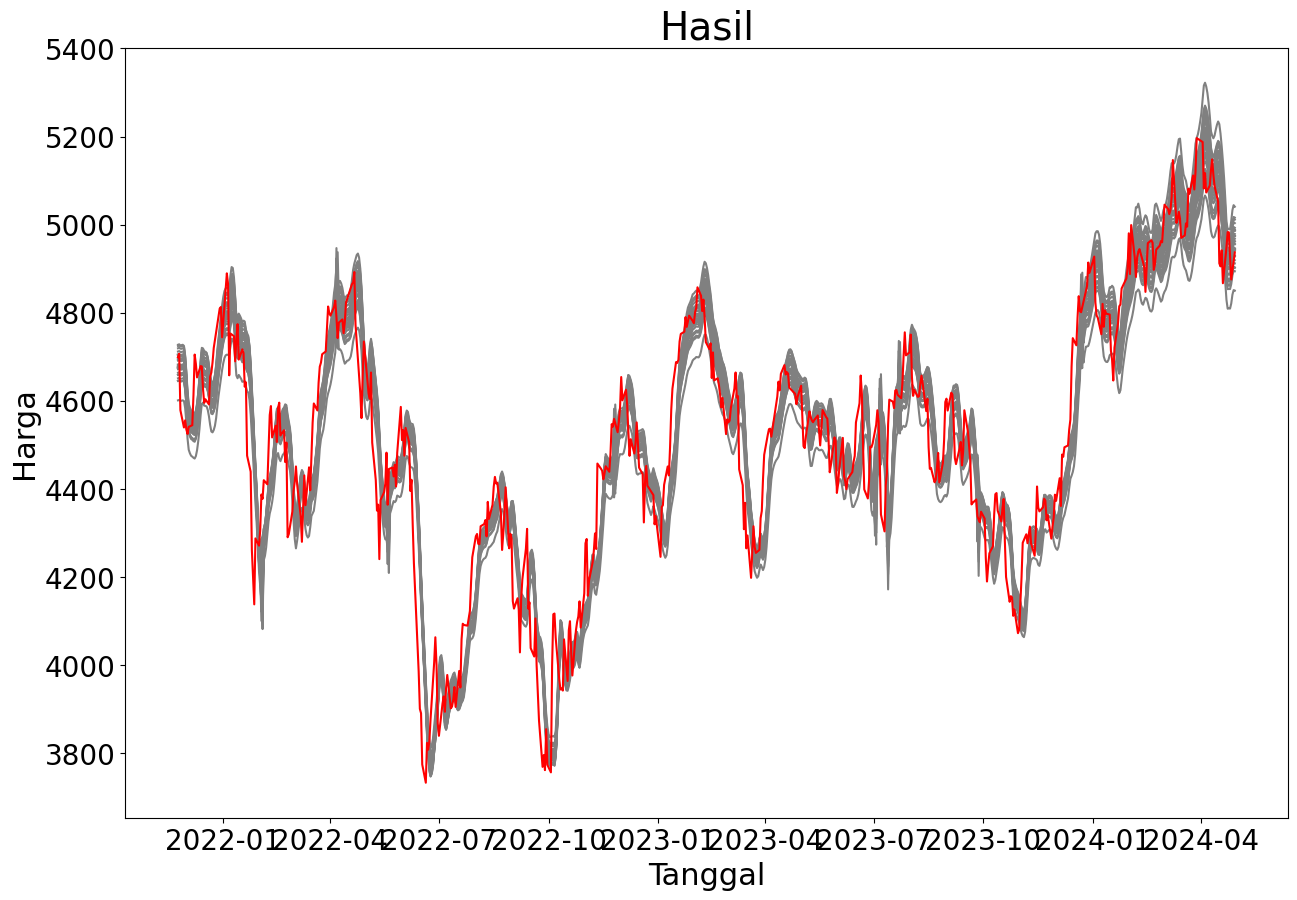

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

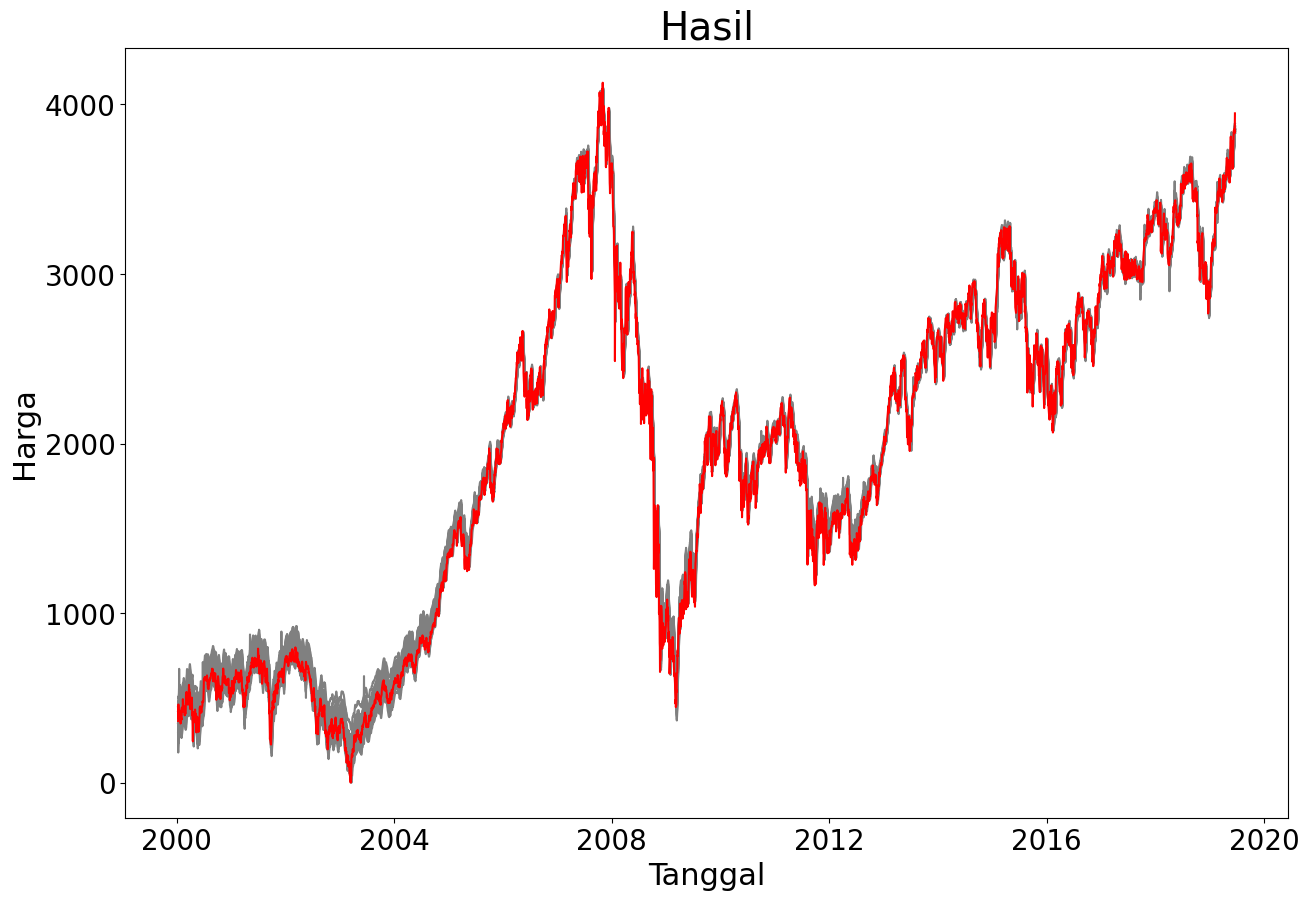

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## LSTM dengan Input Harga Saham dan Keputusan Jual Beli

In [ ]:
datacopy = data_full[3:]
datacopy

In [ ]:
datacopy['EMA_50'] = datacopy['Close'].ewm(span=50, adjust=False).mean()
datacopy['EMA_200'] = datacopy['Close'].ewm(span=200, adjust=False).mean()
datacopy['Diff']= datacopy['EMA_50']-datacopy['EMA_200']
datacopy['sign'] = datacopy['Diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
datacopy['sign_change'] = datacopy['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
filter = datacopy[datacopy['sign_change'] == 1]
idx_datafull = filter.index
datacopy['label'] = np.where(
    (datacopy['sign'] == 1) & (datacopy['sign_change'] != 0), 'Sell',
    np.where((datacopy['sign'] == -1) & (datacopy['sign_change'] != 0), 'Buy', 'Keep')
)
check = datacopy[datacopy['sign_change'] != 0]
check

In [ ]:
datacopy['label1'] = datacopy['label'].apply(lambda x: -1 if x == 'Sell' else (1 if x == 'Buy' else 0))
datacopy
check = datacopy[datacopy['label1'] != 0]
check

In [ ]:
#data_full['Close'] = pd.to_numeric(datacopy['Close'])
#datacopy['label1'] = pd.to_numeric(datacopy['label1'])

X_actual, y_actual, dates_actual = windowed_df_close(datacopy[['Close','label1']],2)
banyakn = len(X_actual)
Mq_80 = int(banyakn * .8)
Mq_90 = int(banyakn * .9)
dates_actual_train, X_actual_train, y_actual_train = dates_actual[:Mq_80], X_actual[:Mq_80], y_actual[:Mq_80]
dates_actual_val, X_actual_val, y_actual_val = dates_actual[Mq_80:Mq_90], X_actual[Mq_80:Mq_90], y_actual[Mq_80:Mq_90]
dates_actual_test, X_actual_test, y_actual_test = dates_actual[Mq_90:], X_actual[Mq_90:], y_actual[Mq_90:]

In [ ]:
datacopy

In [ ]:
y_actual.shape

In [ ]:
from hyperopt import hp

space = {
    'hiddenLayerOne': hp.choice('hiddenLayerOne', [32, 64, 128]),
    'hiddenLayerTwo': hp.choice('hiddenLayerTwo', [32, 64, 128]),
    'activation': hp.choice('activation', ['tanh', 'relu']),
    'epochs': hp.choice('epochs',[50,100,150,200]),
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01]),
    'dropout': hp.choice('dropout', [0.1, 0.2, 0.3]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

def objective(params):
    model = Sequential([
        LSTM(params['hiddenLayerOne'], activation=params['activation'], return_sequences=True, input_shape=(2, 2)),
        Dropout(params['dropout']),
        LSTM(params['hiddenLayerTwo'], activation=params['activation']),
        Dropout(params['dropout']),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='mse',
                  metrics=['mean_absolute_error'])

    es = EarlyStopping(monitor='val_loss',mode='min',
                       verbose=1,patience=5)

    model.fit(X_actual_train, y_actual_train, batch_size=int(params['batch_size']),validation_data=(X_actual_val, y_actual_val))

    score, acc = model.evaluate(X_actual_val, y_actual_val, verbose=0)

    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params}

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
trials = Trials()

In [ ]:
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=175,
  trials=trials)

In [ ]:
space_eval(space, best_params)

In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (2,2)),
    layers.Dropout(0.2),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

RUN

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta = 0.0001,
    restore_best_weights=True
)

In [ ]:
result = []
mapes = []
prediction_result = []
histories = []

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    history = model.fit(X_actual_train, y_actual_train, batch_size=128, validation_data=(X_actual_val, y_actual_val), epochs=50)

    result.append(history)
    histories.append(history.history)

    predictions = model.predict(X_actual_test).flatten()
    mape = mean_absolute_percentage_error(y_actual_test, predictions)
    prediction_result.append(predictions)
    mapes.append(mape)
    print(f"Iteration {i+1}: MAPE = {mape}")

In [ ]:
import numpy as np

all_train_loss = np.array([h['loss'] for h in histories])
all_val_loss = np.array([h['val_loss'] for h in histories])

mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_train_loss, label='Rata-rata Training Loss')
plt.plot(mean_val_loss, label='Rata-rata Validation Loss')
plt.title('Rata-rata Loss per Epoch dari 30 Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prediction_df = pd.DataFrame(prediction_result).transpose()
prediction_df.index = dates_actual_test
prediction_df.columns = [f'Iterasi {i+1}' for i in range(prediction_df.shape[1])]
print(prediction_df)

In [ ]:
prediction_df2 = prediction_df.copy(deep=True)
print(prediction_df2)

In [ ]:
prediction_df2 = prediction_df2.multiply(range_value)
print(prediction_df2)

In [ ]:
y_test2 = y_actual_test * range_value
y_test2

In [ ]:
prediction_df2['Rata2'] = prediction_df2.mean(axis=1)
print(prediction_df2)

In [ ]:
from math import sqrt
hasil = prediction_df2['Rata2']
close_test_mae = mean_absolute_error(y_test2, hasil)
close_test_mse = mean_squared_error(y_test2, hasil)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, hasil)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

In [ ]:
prediction_df2.to_csv('hasilprediksilstm2fit_INDO.csv')